In [1]:
#we load the necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs

quarters = ['2023_Q1', '2023_Q3', '2023_Q4',
            '2024_Q2', '2024_Q4',
            '2025_Q1', '2025_Q2']
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller


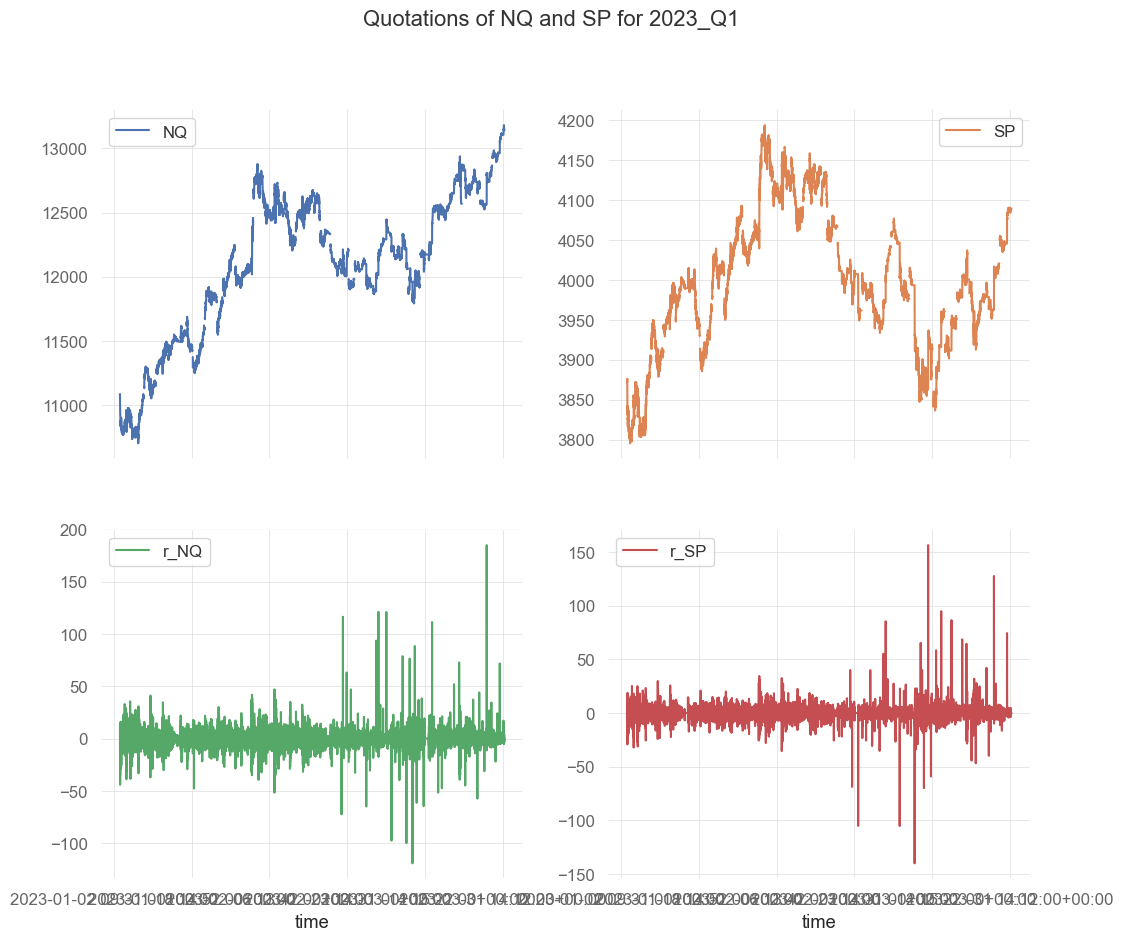

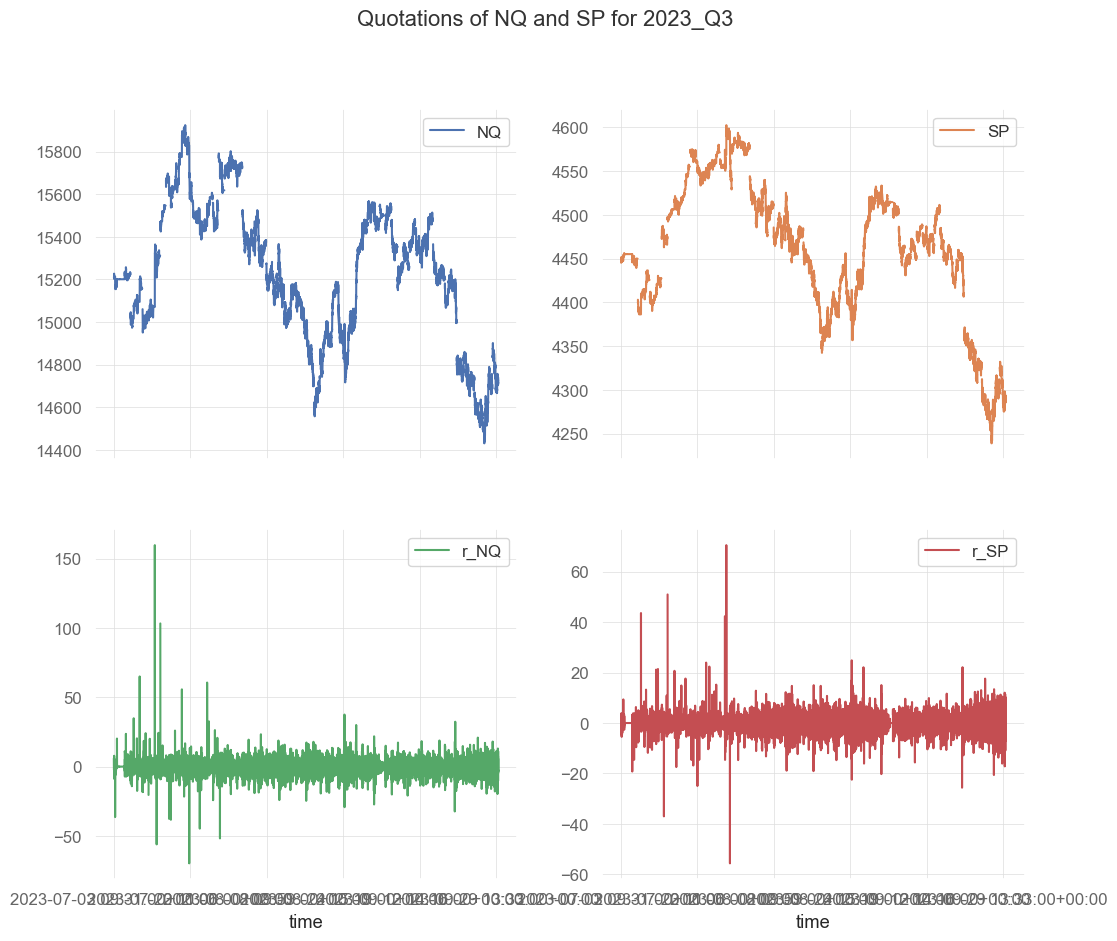

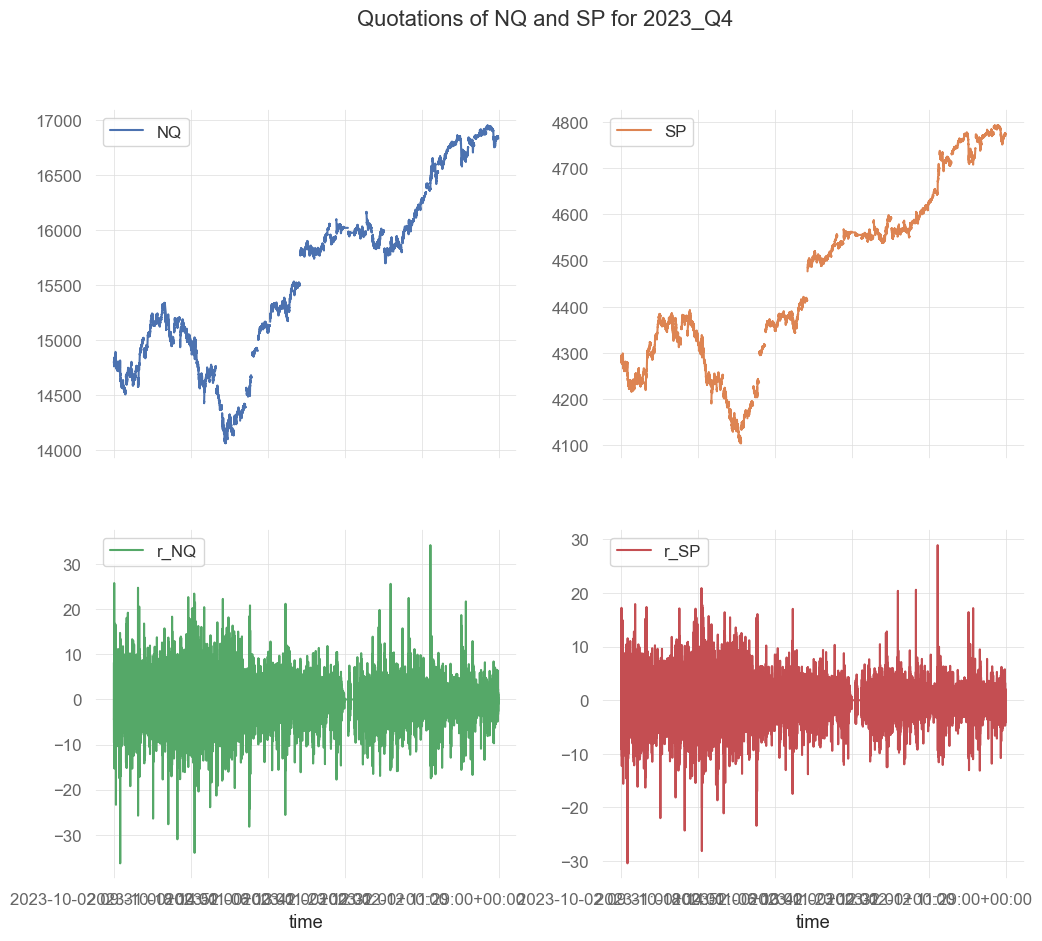

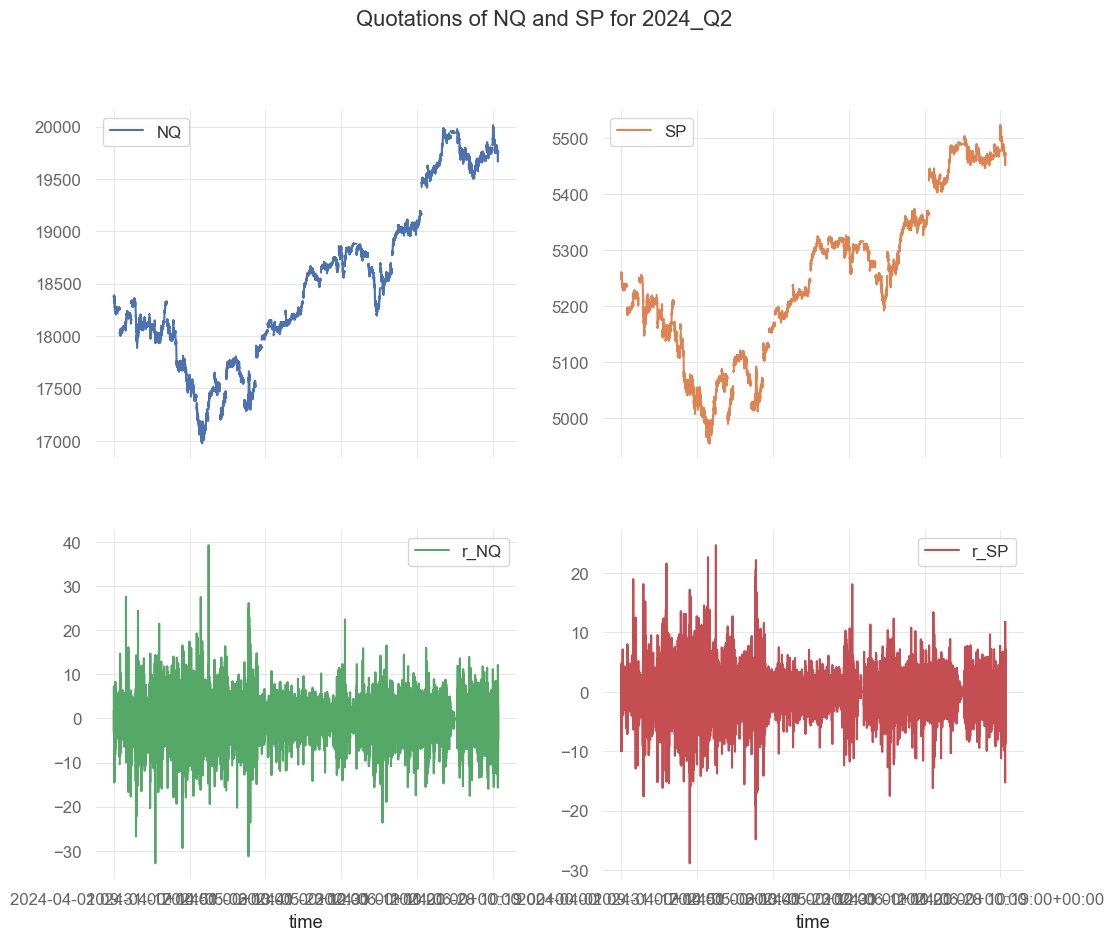

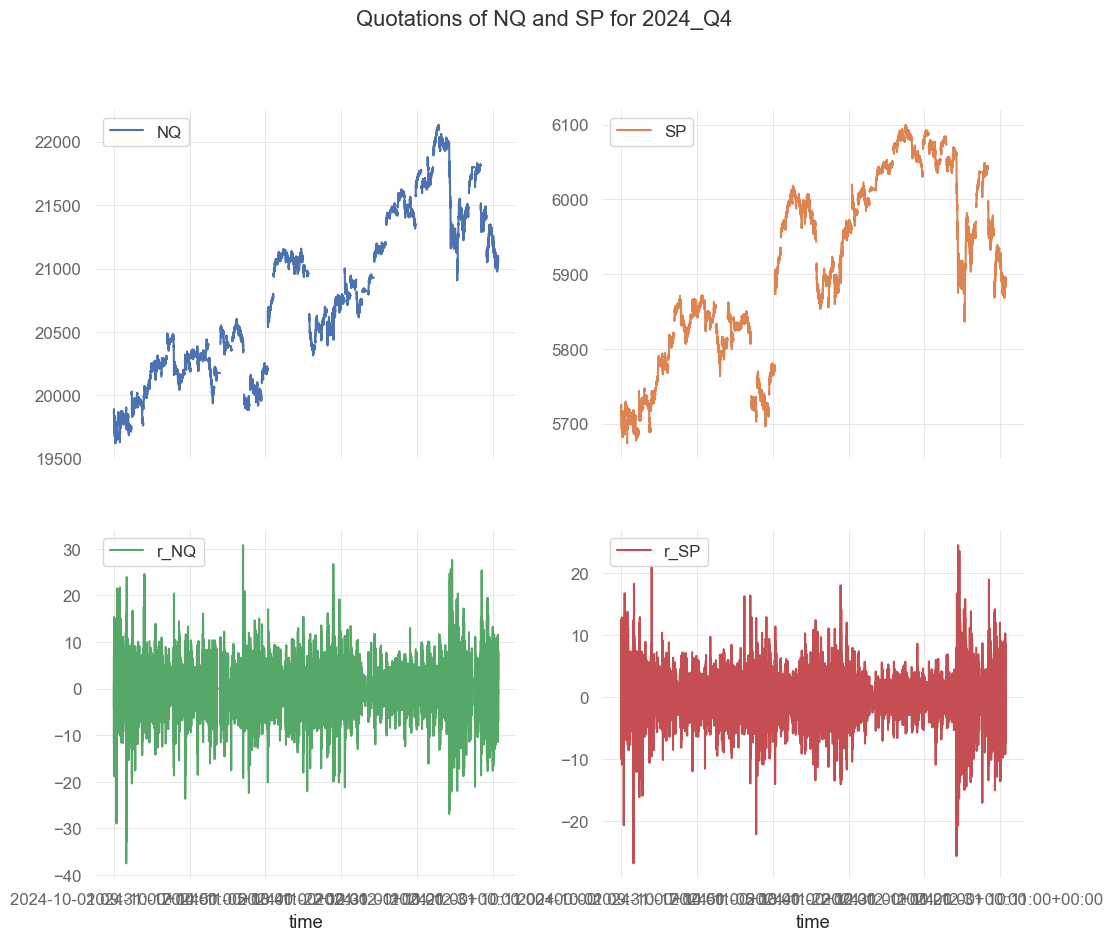

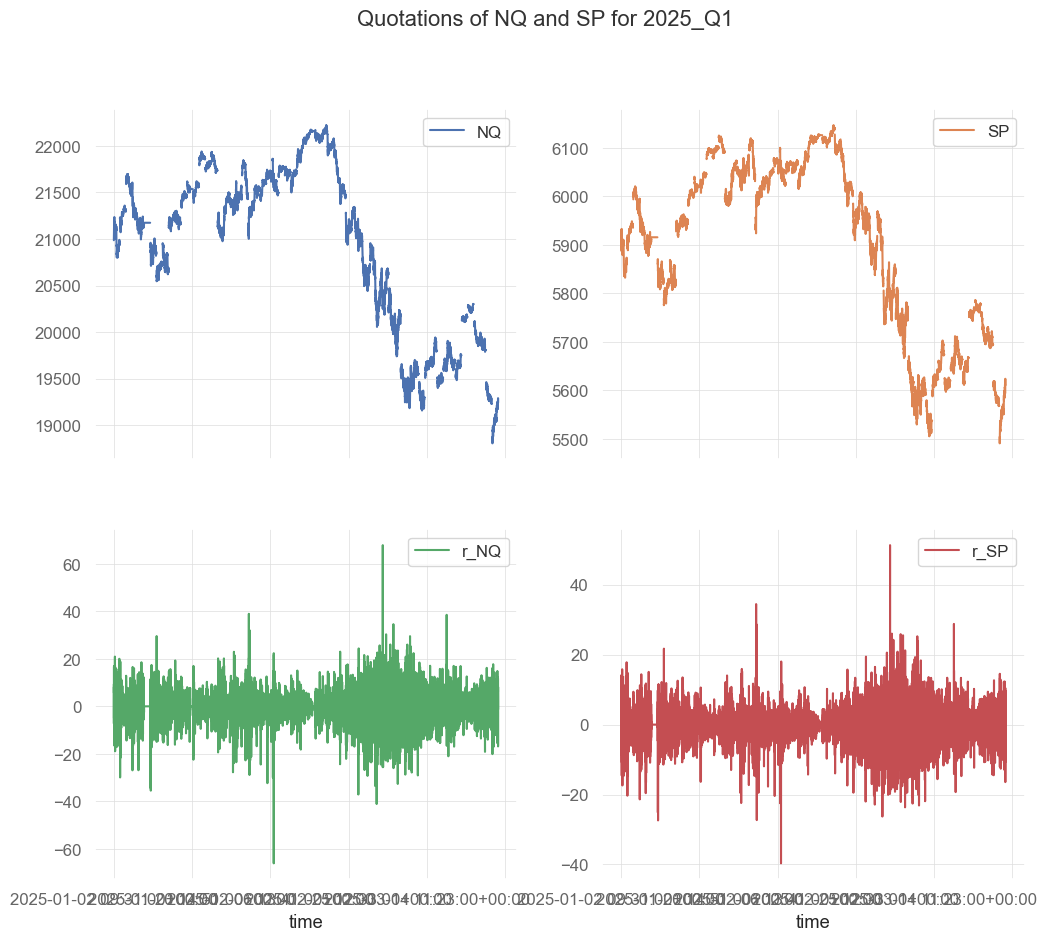

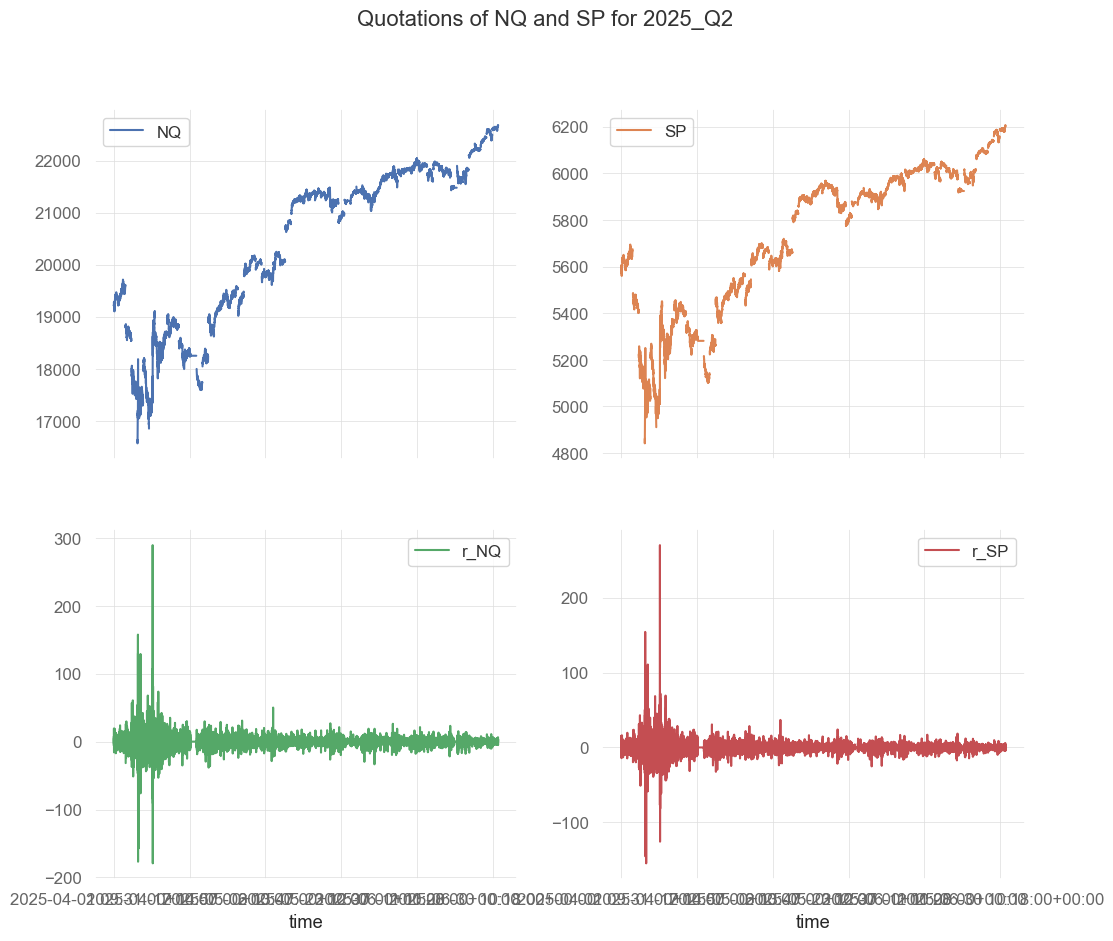

In [2]:
# Combine all quarterly data into one file with quarter identification
all_data_list = []

for quarter in quarters:
    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')
    data1['datetime'] = pd.to_datetime(data1['datetime'])
    data1.set_index('datetime', inplace=True)
    
    data_r = np.log(data1 / data1.shift(1)) * 10000
    data_r.columns = ['r_' + col for col in data_r.columns]
    
    data_NQ_SP_temp = pd.concat(
        [data1[['NQ', 'SP']],
        data_r[['r_NQ', 'r_SP']]],
        axis=1
    )
    
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("9:31", "9:40").index] = np.nan
    data_NQ_SP_temp.loc[data_NQ_SP_temp.between_time("15:51", "16:00").index] = np.nan
    
    data_NQ_SP_plot = data_NQ_SP_temp.copy()
    data_NQ_SP_plot['time'] = data_NQ_SP_plot.index.astype(str)

    # We reset the index to make 'time' a column
    data_NQ_SP_plot = data_NQ_SP_plot.reset_index(drop = True)

    # Let's set time as the X-axis and draw the graphs
    data_NQ_SP_plot.plot(
        x = 'time',
        subplots = True,
        layout = (2, 2),
        title = "Quotations of NQ and SP for" + f" {quarter}",
        figsize = (12, 10)
    )
    plt.show()
    
    # Add quarter column
    data_NQ_SP_temp['quarter'] = quarter
    
    all_data_list.append(data_NQ_SP_temp)

# Combine all data
all_data = pd.concat(all_data_list, axis=0)


In [4]:
from functions.position_VB import positionVB

In [17]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create an empty DataFrame to store summary for all quarters
summary_2MAs = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')

    # Lets set the datetime index
    data1.set_index('datetime', inplace = True)

    # assumption 1
    # do not use in calculations the data from the first and last 10 minutes
    # of the session (9:31-9:40 and 15:51-16:00) – put missing values there,
    data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    # assumption 2
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data1))

    # do not trade within the first 25 minutes of stocks quotations (9:31-9:55),
    pos_flat[data1.index.time <= pd.to_datetime("9:55").time()] = 1

    # do not hold positions overnight (exit all positions 20 minutes
    # before the session end, i.e. at 15:40),
    pos_flat[data1.index.time >= pd.to_datetime("15:40").time()] = 1

    # apply the strategy
    ##############################################################
    SP = data1['SP']

    for fastEMA in fastEMA_parameters:
        for slowEMA in slowEMA_parameters:

                    # ensure that fastEMA is less than slowEMA
                    if fastEMA >= slowEMA:
                        continue

                    print(f"  fastEMA = {fastEMA}, slowEMA = {slowEMA}")

                    # We calculate the appropriate EMA
                    fastEMA_values = SP.ewm(span = fastEMA).mean()
                    slowEMA_values = SP.ewm(span = slowEMA).mean()

                    # Insert NaNs wherever the original price is missing
                    fastEMA_values[data1['SP'].isna()] = np.nan
                    slowEMA_values[data1['SP'].isna()] = np.nan

                    # Calculate position for momentum strategy
                    cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)

                    # let's add filters that check for the presence of NaN values
                    fastEMA_nonmiss = fastEMA_values.shift(1).notna()
                    slowEMA_nonmiss = slowEMA_values.shift(1).notna()

                    # Now we can add these conditions to our strategies
                    # if any of the values is missing,
                    # we cannot make a position decision

                    pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                                       np.where(cond2b_mom_long, 1, -1),
                                       np.nan)
                    pos_mr = -pos_mom

                    # Set position to 0 where pos_flat is 1
                    pos_mom[pos_flat == 1] = 0
                    pos_mr[pos_flat == 1] = 0

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * data1["SP"].diff()), 0, pos_mom * data1["SP"].diff() * 50)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * data1["SP"].diff()), 0, pos_mr * data1["SP"].diff() * 50)
                    # point value for SP

                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 12 # cost $12 per transaction
                    pnl_net_mr = pnl_gross_mr - ntrans * 12   # cost $12 per transaction

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = data1['SP'].index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(data1['SP'].index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = data1['SP'].index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(data1['SP'].index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = data1['SP'].index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(data1['SP'].index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = data1['SP'].index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(data1['SP'].index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = data1['SP'].index.time
                    ntrans_d = ntrans.groupby(data1['SP'].index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()
                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom/1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr/1000)))

                    # Collect necessary results into one object
                    summary = pd.DataFrame({
                        'fastEMA': fastEMA,
                        'slowEMA': slowEMA,
                        'quarter': quarter,
                        'gross_SR_mom': gross_SR_mom,
                        'net_SR_mom': net_SR_mom,
                        'gross_PnL_mom': gross_PnL_mom,
                        'net_PnL_mom': net_PnL_mom,
                        'gross_SR_mr': gross_SR_mr,
                        'net_SR_mr': net_SR_mr,
                        'gross_PnL_mr': gross_PnL_mr,
                        'net_PnL_mr': net_PnL_mr,
                        'av_daily_ntrans': av_daily_ntrans,
                        'stat_mom': stat_mom,
                        'stat_mr': stat_mr
                    }, index=[0])

                    # Append results to the summary
                    summary_2MAs = pd.concat([summary_2MAs, summary], ignore_index=True)

Processing quarter: 2023_Q1
  fastEMA = 15, slowEMA = 90
  fastEMA = 15, slowEMA = 120
  fastEMA = 15, slowEMA = 150
  fastEMA = 15, slowEMA = 180
  fastEMA = 15, slowEMA = 240
  fastEMA = 15, slowEMA = 300
  fastEMA = 15, slowEMA = 360
  fastEMA = 15, slowEMA = 420
  fastEMA = 20, slowEMA = 90
  fastEMA = 20, slowEMA = 120
  fastEMA = 20, slowEMA = 150
  fastEMA = 20, slowEMA = 180
  fastEMA = 20, slowEMA = 240
  fastEMA = 20, slowEMA = 300
  fastEMA = 20, slowEMA = 360
  fastEMA = 20, slowEMA = 420
  fastEMA = 30, slowEMA = 90
  fastEMA = 30, slowEMA = 120
  fastEMA = 30, slowEMA = 150
  fastEMA = 30, slowEMA = 180
  fastEMA = 30, slowEMA = 240
  fastEMA = 30, slowEMA = 300
  fastEMA = 30, slowEMA = 360
  fastEMA = 30, slowEMA = 420
  fastEMA = 45, slowEMA = 90
  fastEMA = 45, slowEMA = 120
  fastEMA = 45, slowEMA = 150
  fastEMA = 45, slowEMA = 180
  fastEMA = 45, slowEMA = 240
  fastEMA = 45, slowEMA = 300
  fastEMA = 45, slowEMA = 360
  fastEMA = 45, slowEMA = 420
  fastEMA = 60, 

In [28]:
summary_2MAs

fastEMA  slowEMA  quarter  gross_SR_mom  net_SR_mom  gross_PnL_mom  \
0         15       90  2023_Q1      0.502407   -0.639865        3407.10   
1         15      120  2023_Q1      1.298023    0.409914        9299.90   
2         15      150  2023_Q1      1.559528    0.784410       11599.30   
3         15      180  2023_Q1      0.686106   -0.054890        4926.20   
4         15      240  2023_Q1      0.789557    0.198185        5995.20   
..       ...      ...      ...           ...         ...            ...   
380       90      180  2025_Q2     -0.082115   -0.364369       -1131.25   
381       90      240  2025_Q2     -0.435139   -0.693082       -5771.35   
382       90      300  2025_Q2     -0.144859   -0.366372       -2028.95   
383       90      360  2025_Q2     -2.018916   -2.235343      -25313.15   
384       90      420  2025_Q2     -1.684032   -1.909151      -19746.05   

     net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  net_PnL_mr  \
0       -4464.90    -0.502407  -1.710816      -3407.10   -11279.10   
1        3011.90    -1.298023  -2.231024      -9299.90   -15587.90   
2        5959.30    -1.559528  -2.367037     -11599.30   -17239.30   
3        -401.80    -0.686106  -1.455570      -4926.20   -10254.20   
4        1531.20    -0.789557  -1.401465      -5995.20   -10459.20   
..           ...          ...        ...           ...         ...   
380     -5043.25     0.082115  -0.202782       1131.25    -2780.75   
381     -9227.35     0.435139   0.175220       5771.35     2315.35   
382     -5148.95     0.144859  -0.078157       2028.95    -1091.05   
383    -28145.15     2.018916   1.800575      25313.15    22481.15   
384    -22482.05     1.684032   1.456902      19746.05    17010.05   

     av_daily_ntrans  stat_mom   stat_mr  
0          10.092308 -1.705520 -5.356700  
1           8.061538 -0.099326 -7.500743  
2           7.230769  0.507658 -8.163005  
3           6.830769 -0.000000 -4.551955  
4           5.723077 -0.128589 -4.463654  
..               ...       ...       ...  
380         5.015385 -1.398592 -0.718750  
381         4.430769 -2.651234 -0.272673  
382         4.000000 -1.419804 -0.050381  
383         3.630769 -9.128866  4.048270  
384         3.507692 -7.499004  2.711673  

[385 rows x 14 columns]

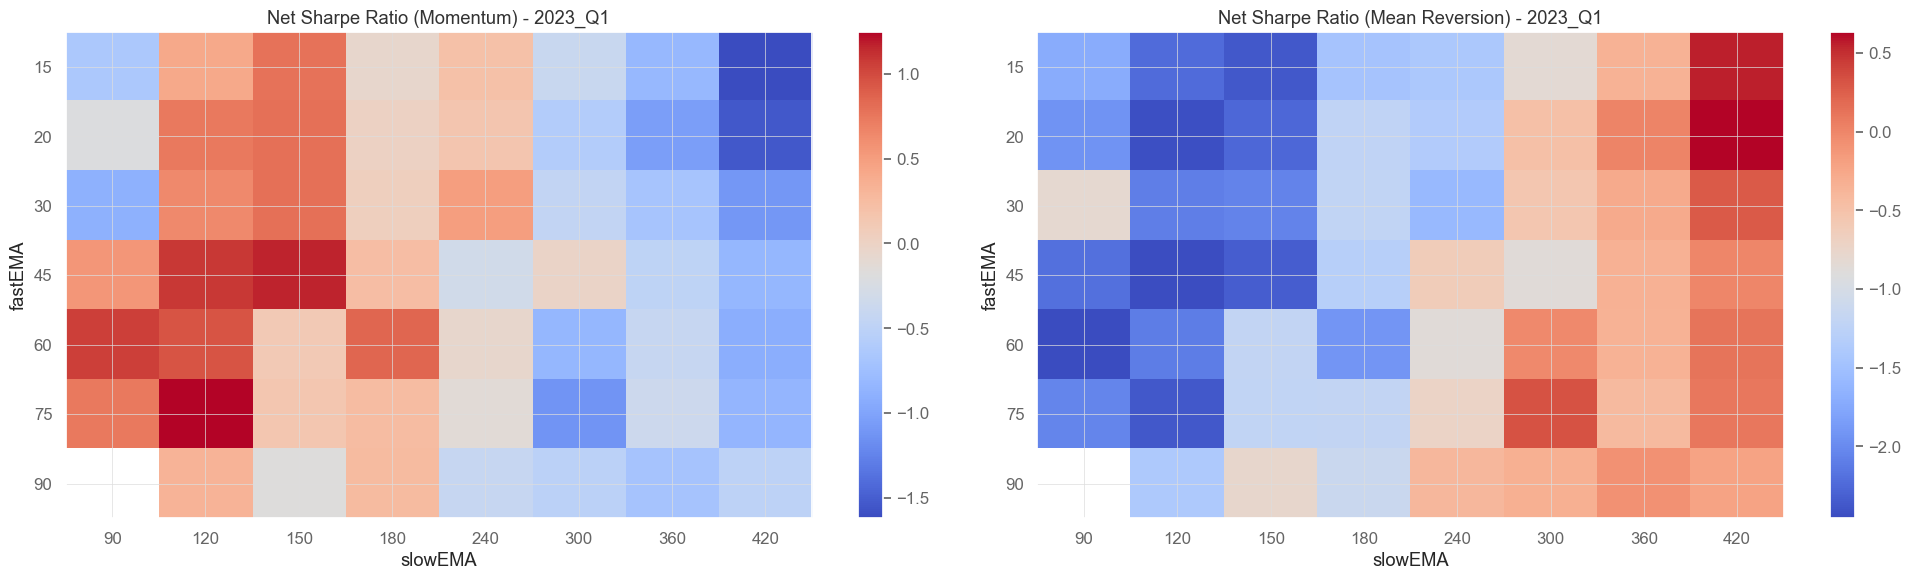

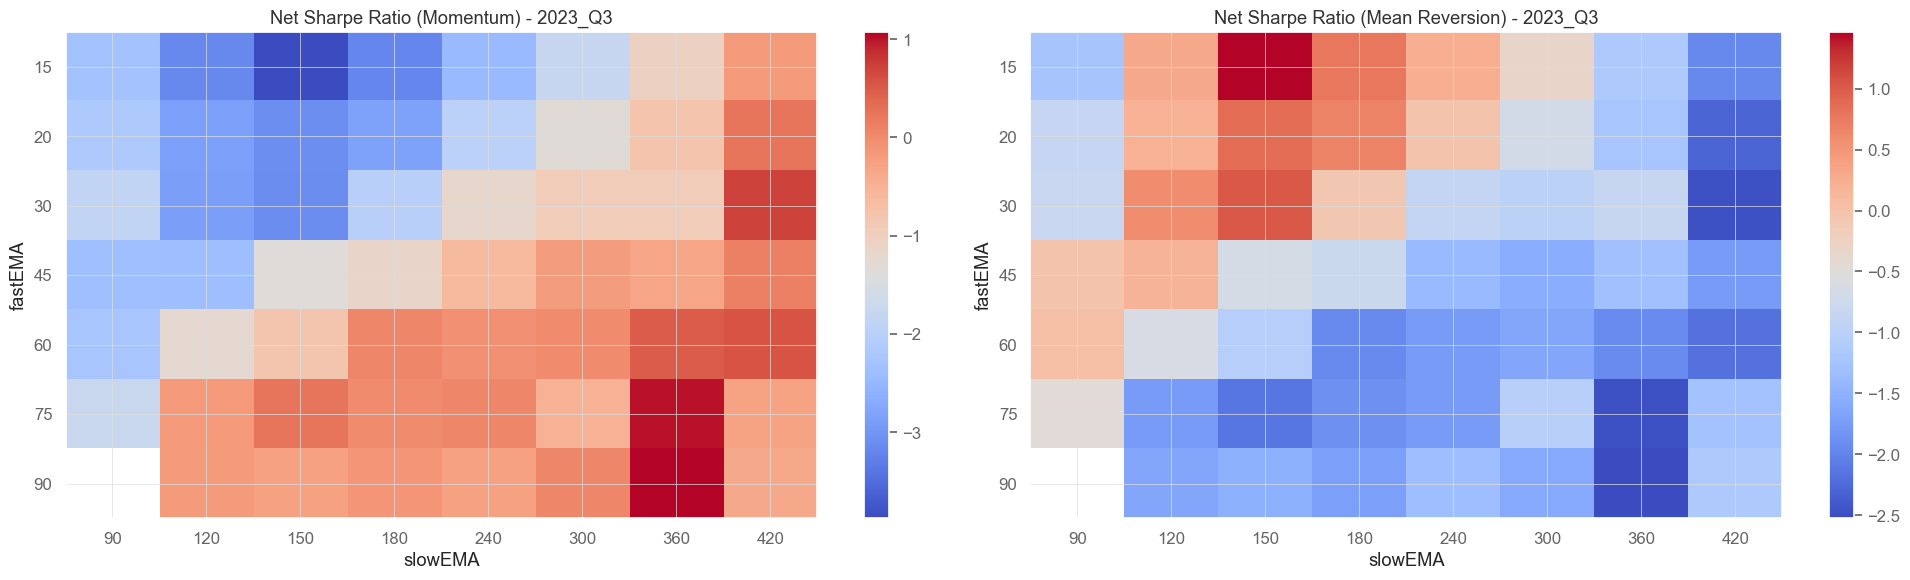

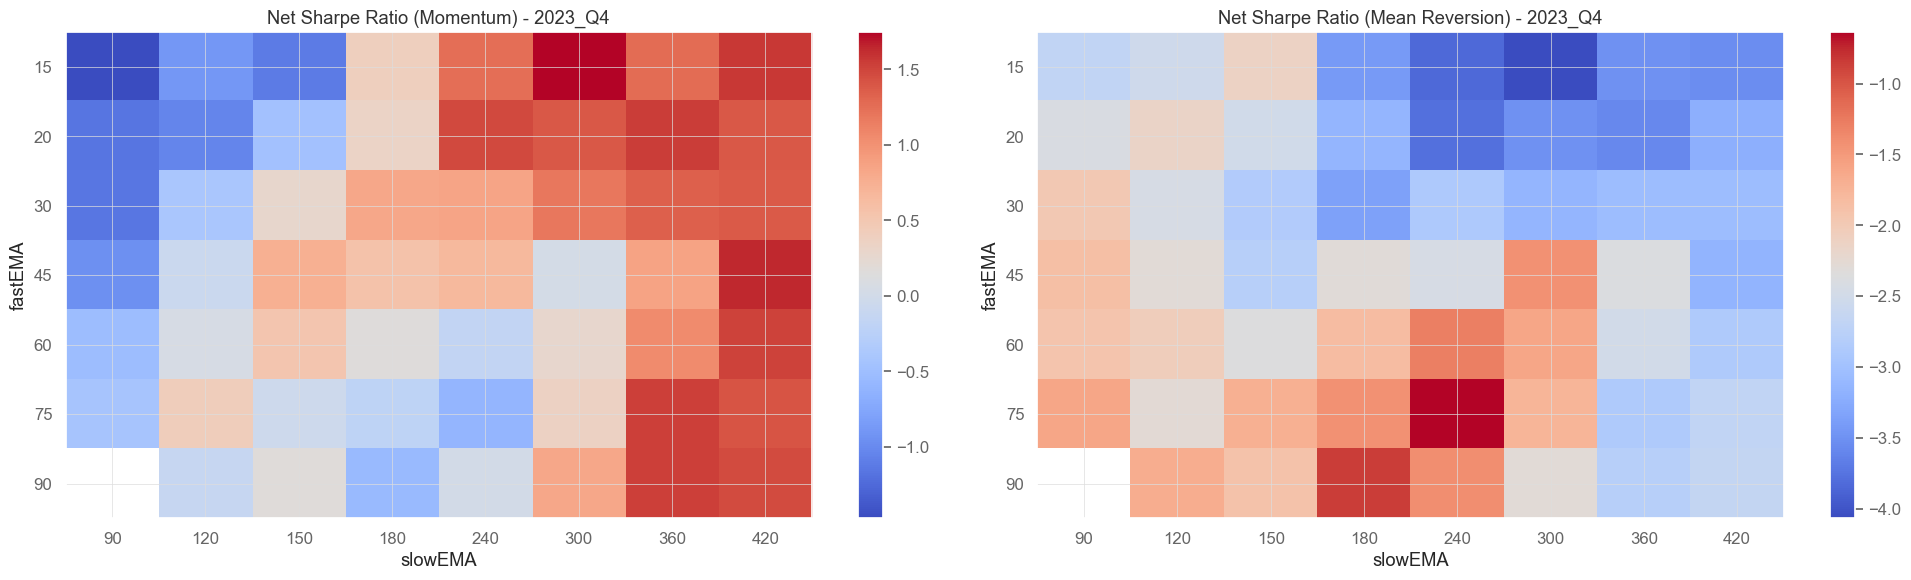

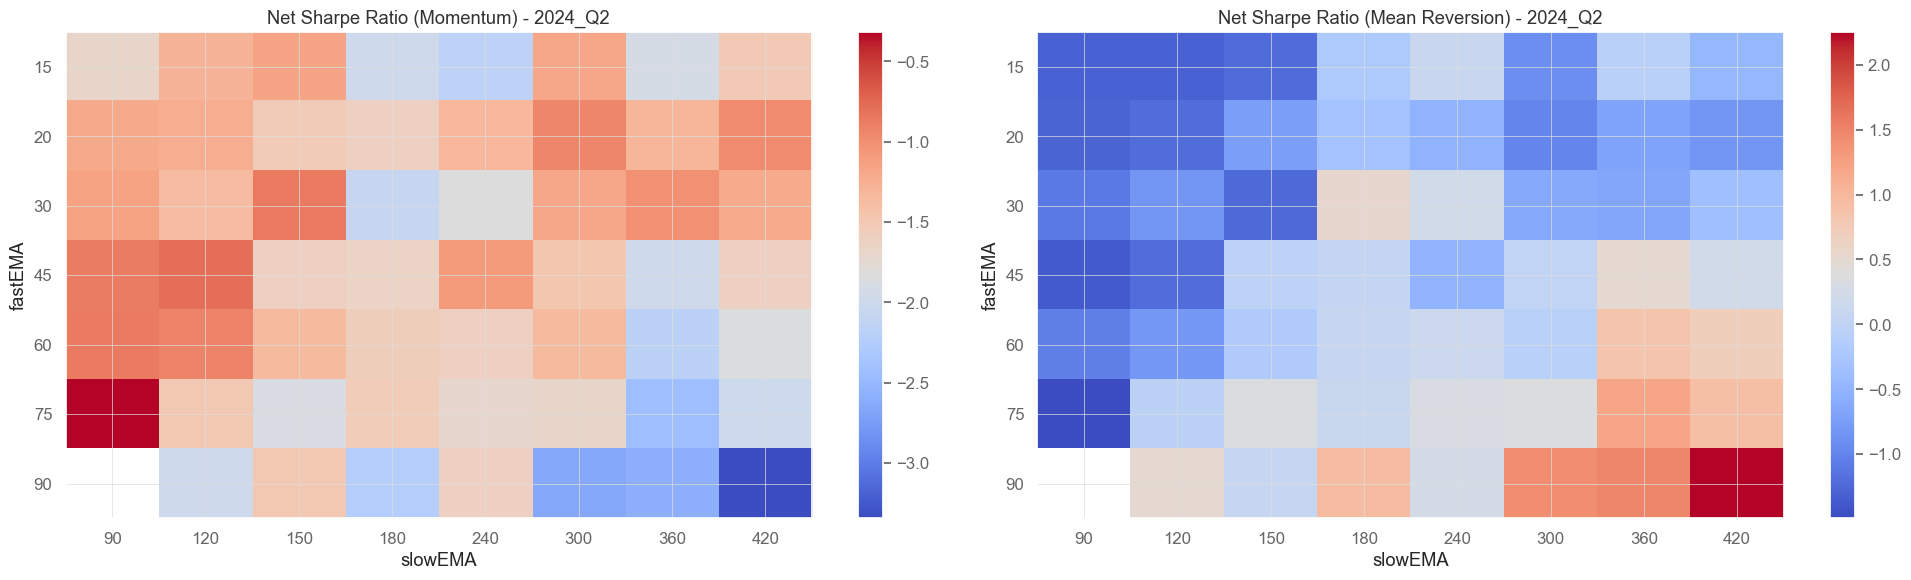

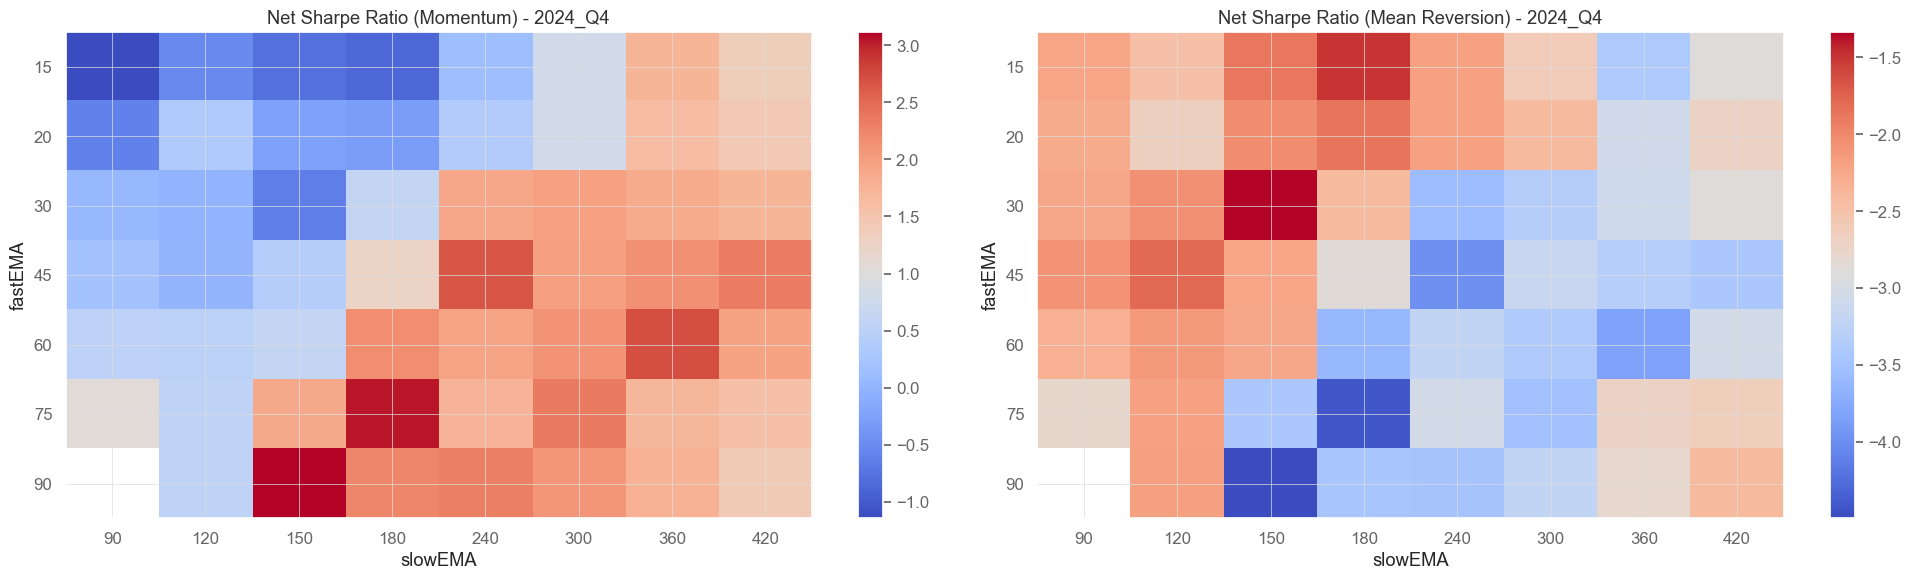

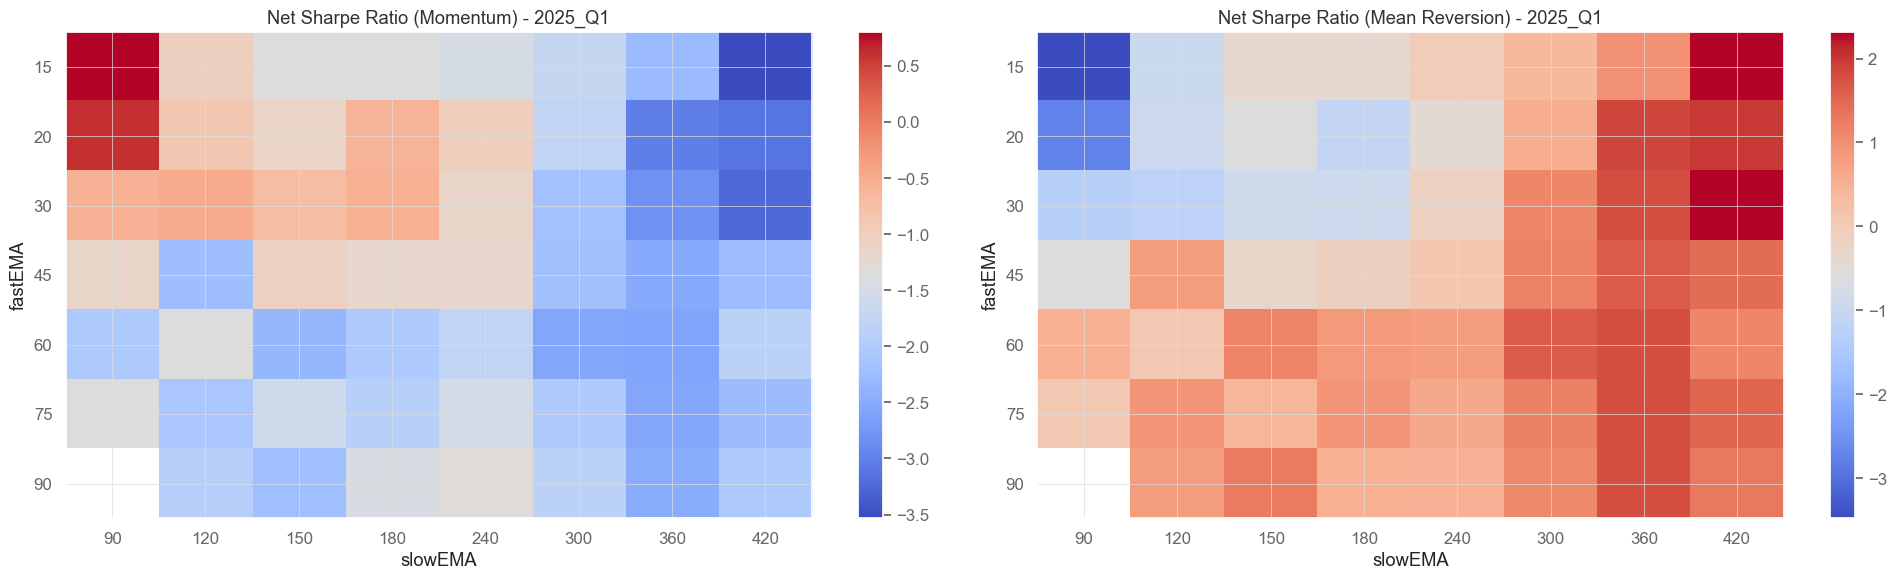

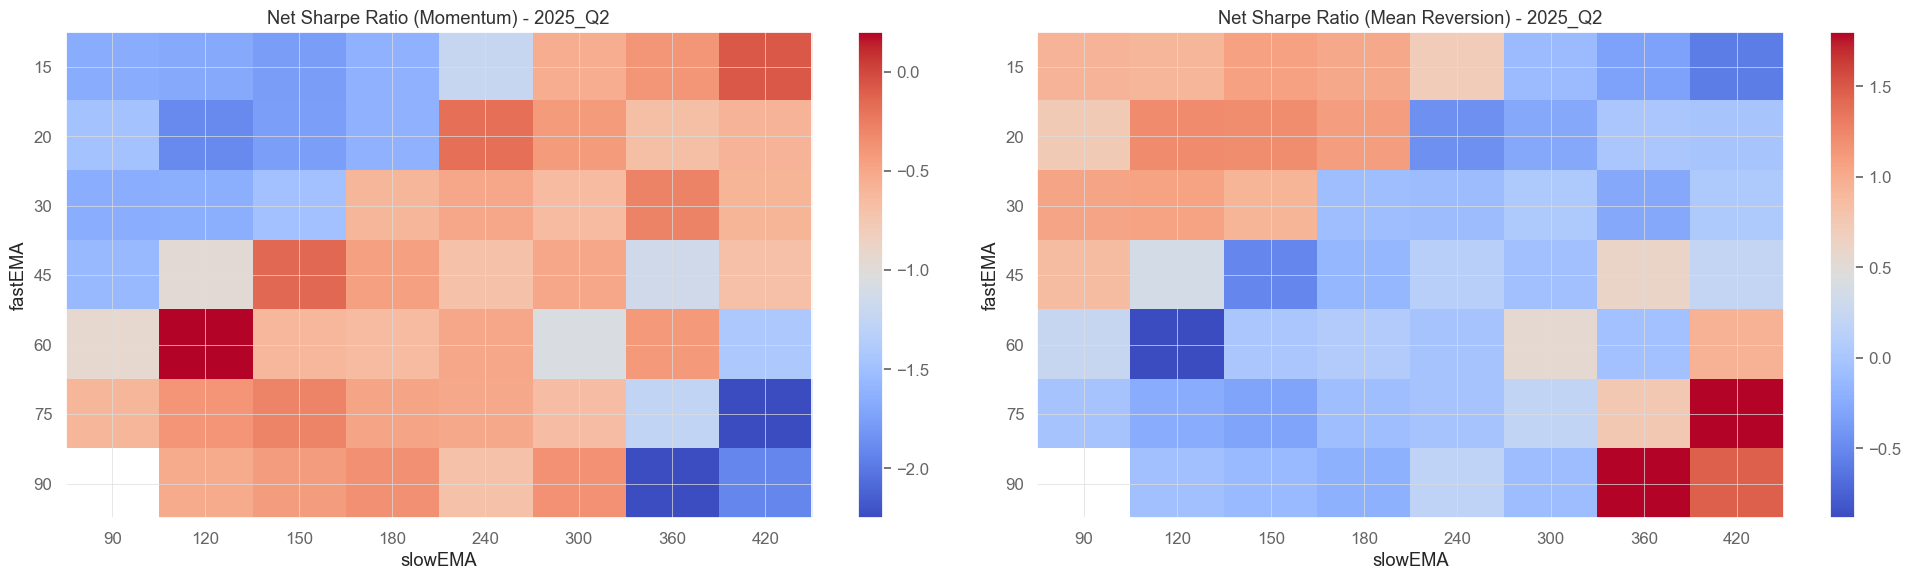

In [18]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_2MAs[summary_2MAs['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_SR_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('slowEMA')
    axes[0].set_ylabel('fastEMA')
    axes[0].set_title(f'Net Sharpe Ratio (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_SR_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[1].set_xlabel('slowEMA')
    axes[1].set_ylabel('fastEMA')
    axes[1].set_title(f'Net Sharpe Ratio (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

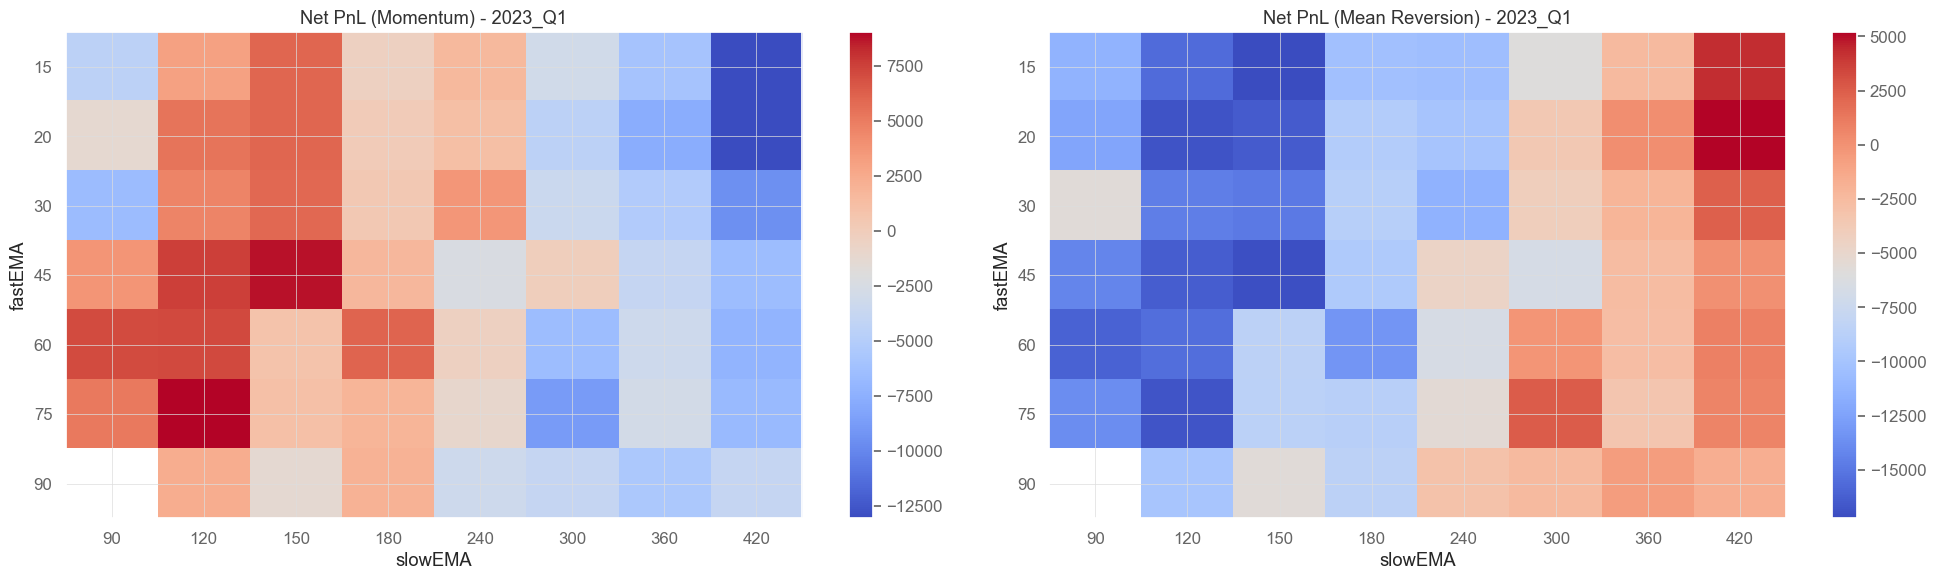

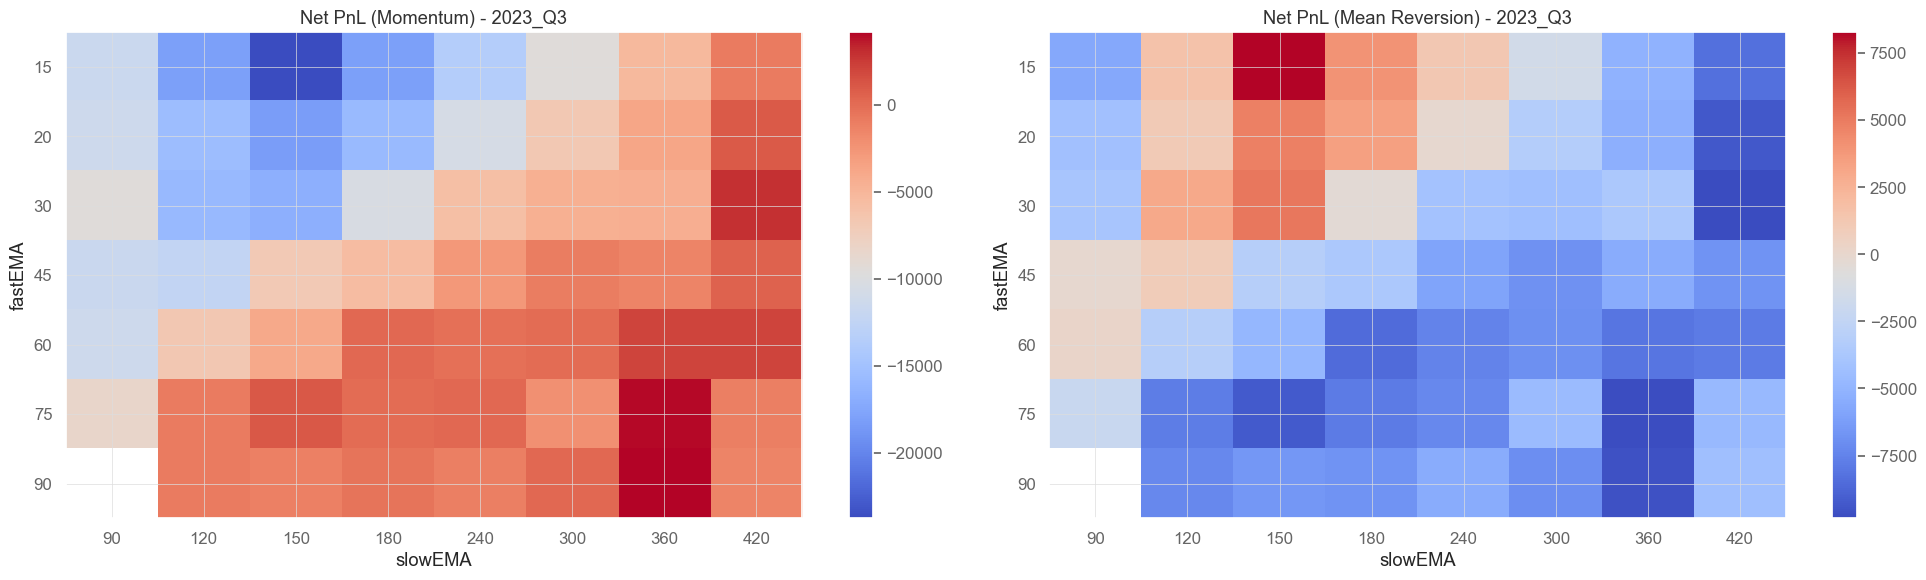

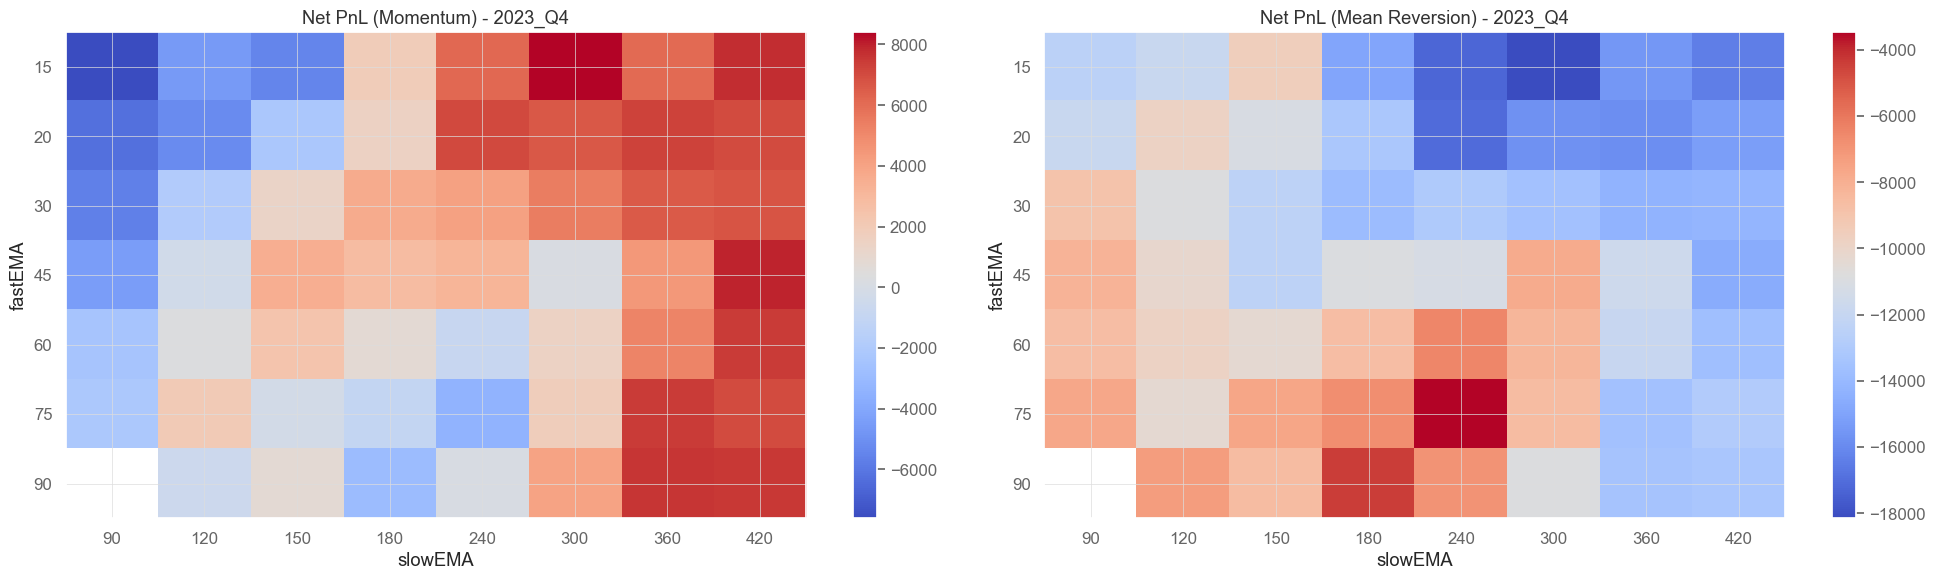

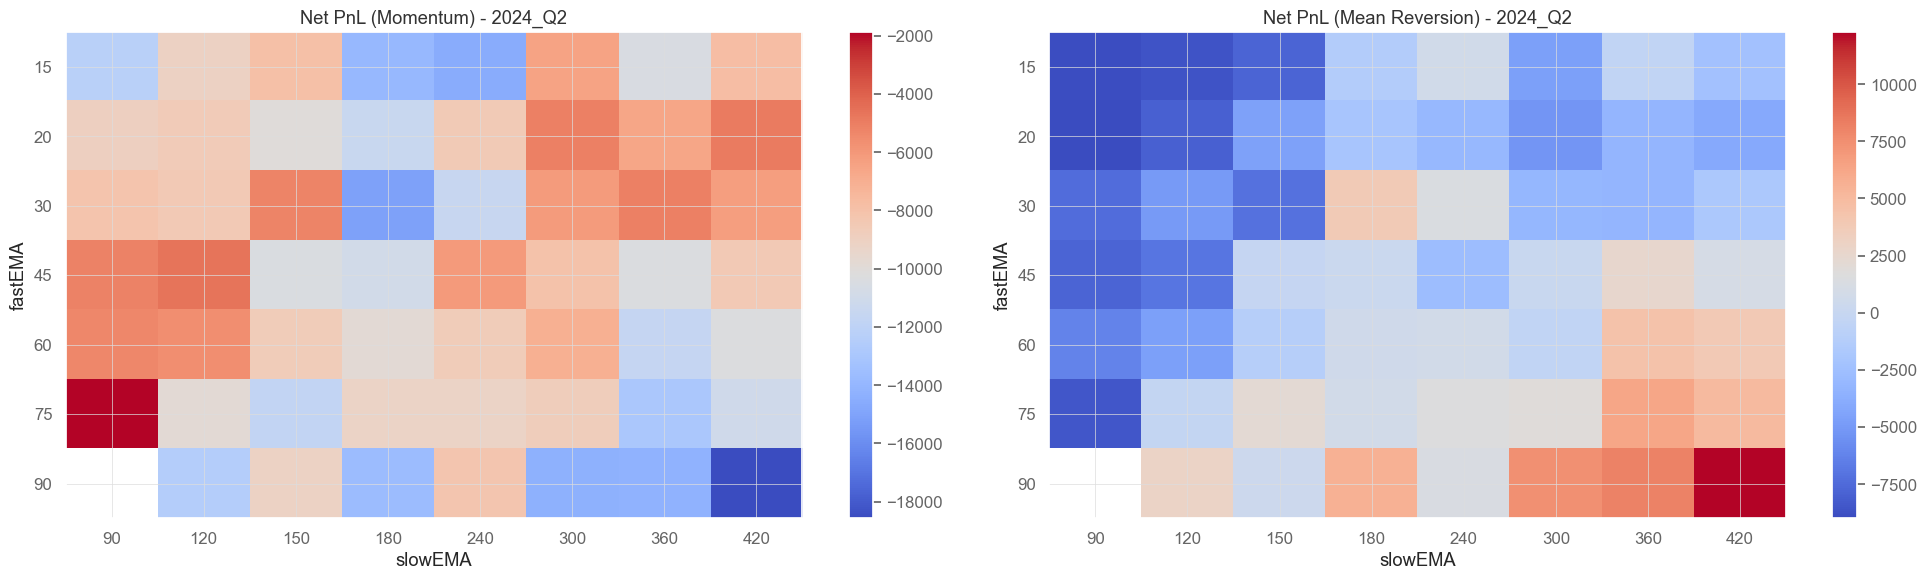

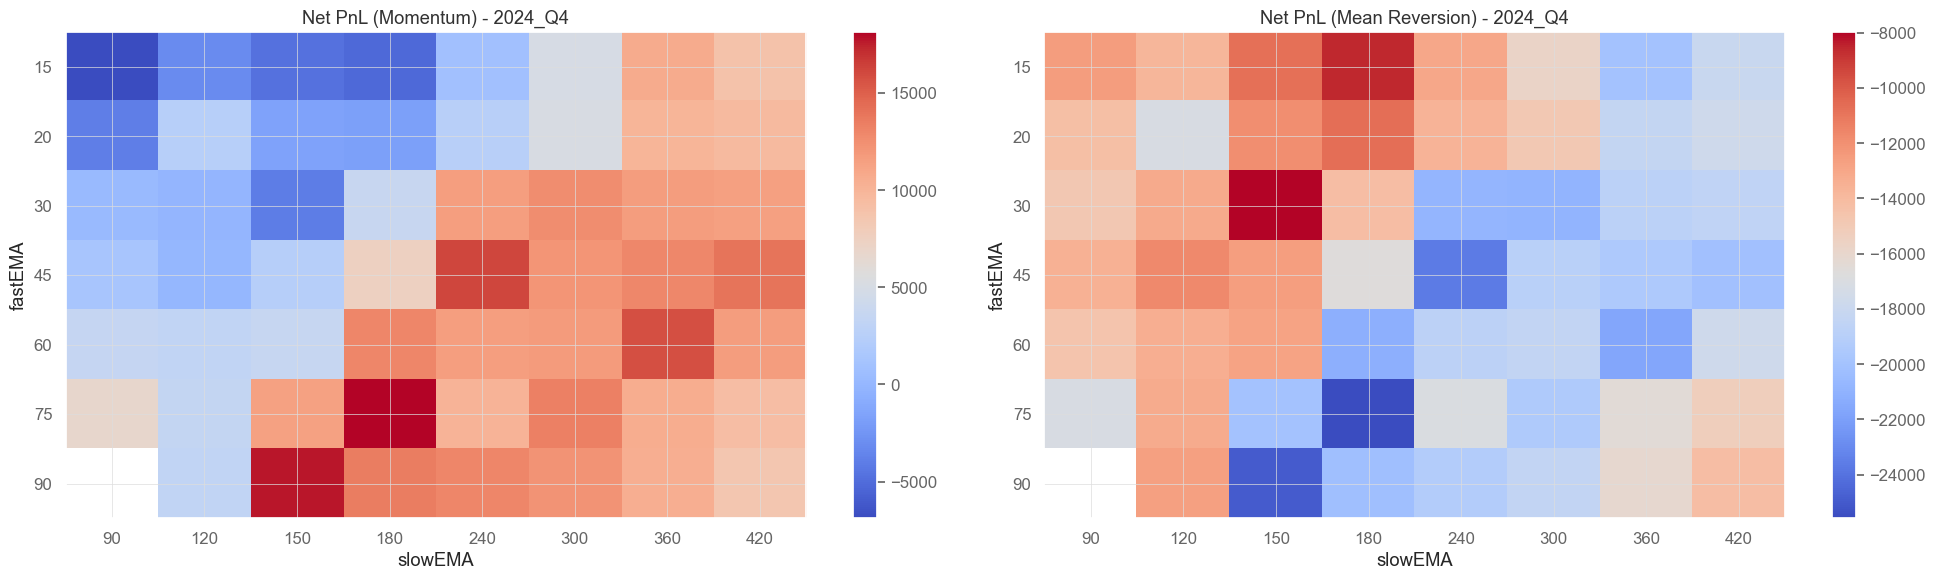

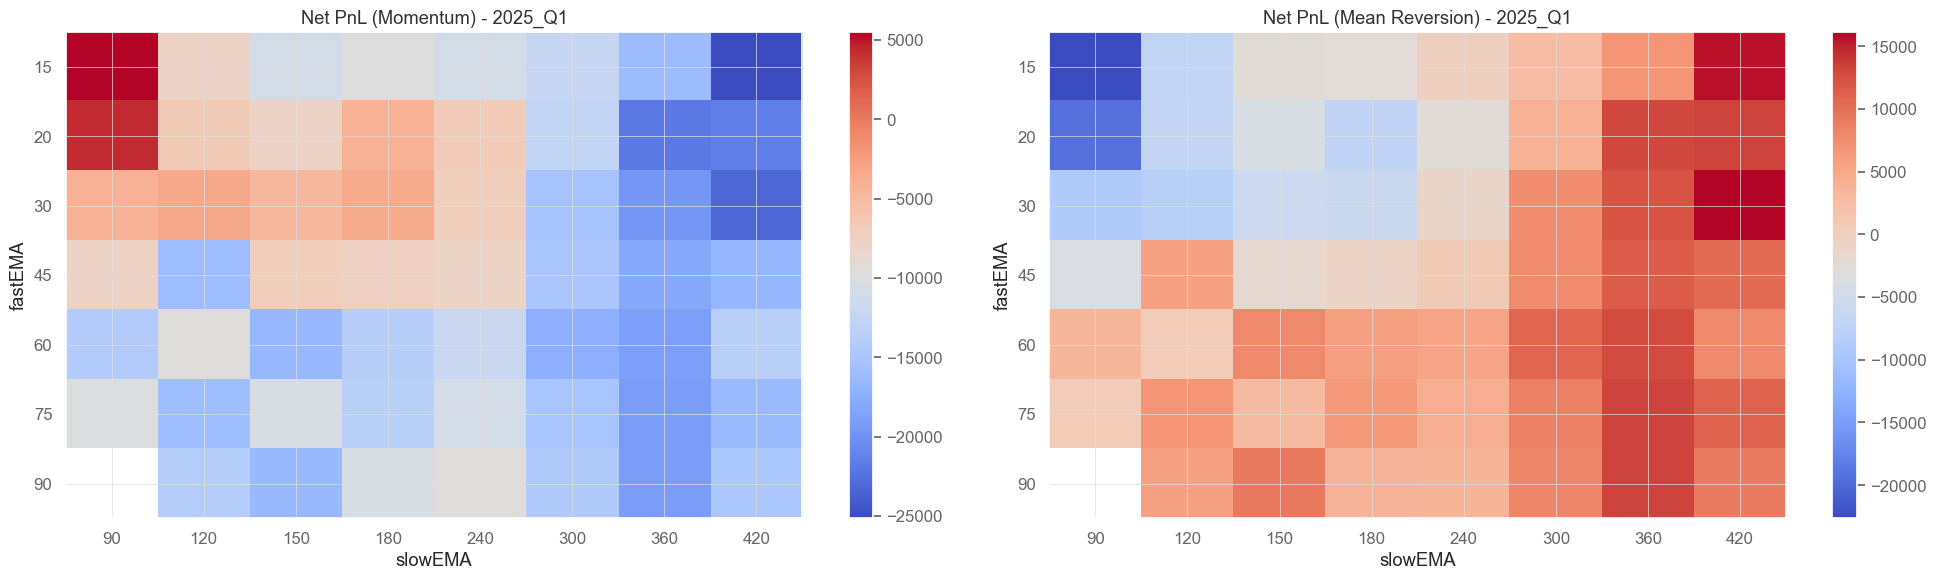

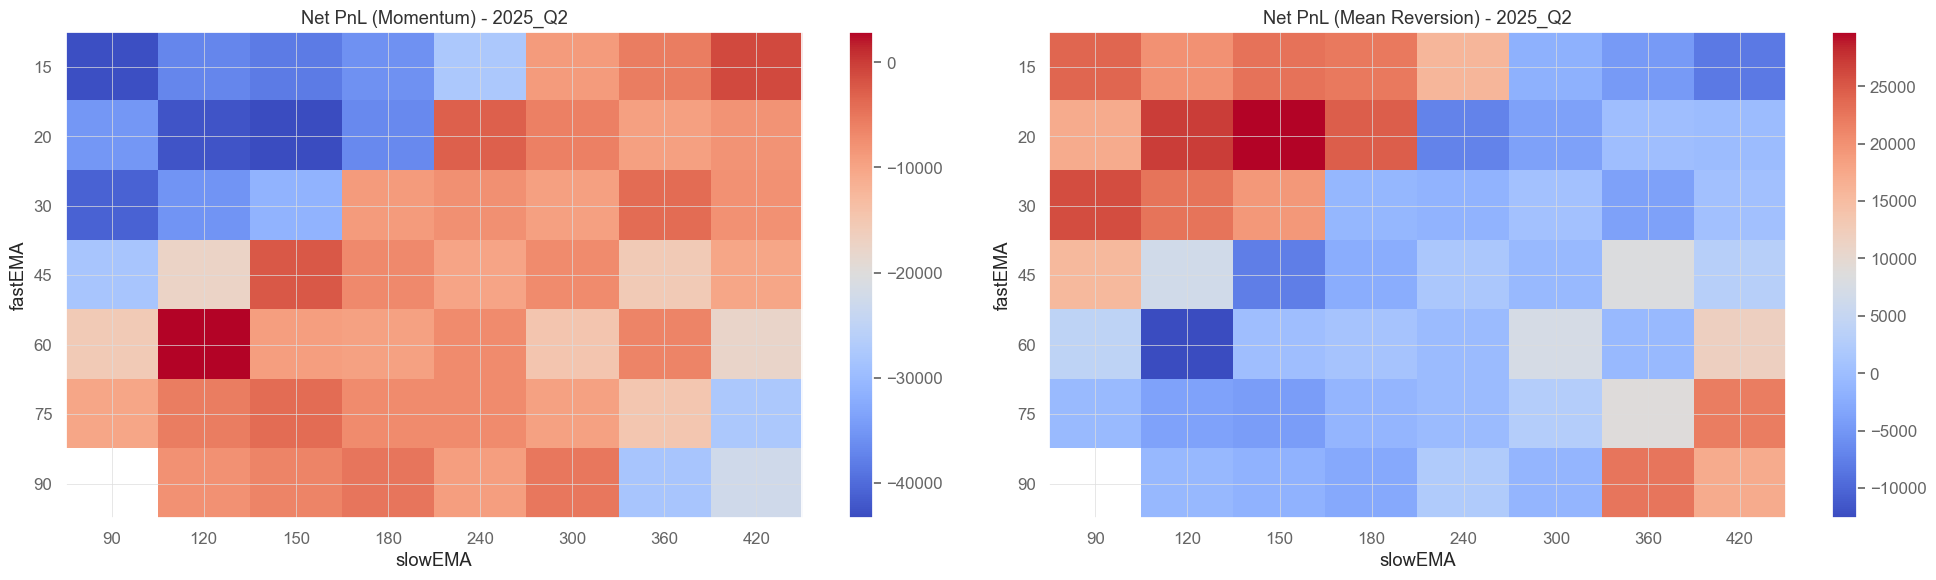

In [33]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_2MAs[summary_2MAs['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_PnL_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('slowEMA')
    axes[0].set_ylabel('fastEMA')
    axes[0].set_title(f'Net PnL (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='fastEMA', columns='slowEMA', values='net_PnL_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[1].set_xlabel('slowEMA')
    axes[1].set_ylabel('fastEMA')
    axes[1].set_title(f'Net PnL (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [39]:
aggregated_stats_2MAs = (
    summary_2MAs
    .groupby(['fastEMA', 'slowEMA'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

In [48]:
aggregated_stats_2MAs['stat_mom_total'] = aggregated_stats_2MAs['stat_mom_total'].round(2)
aggregated_stats_2MAs['stat_mr_total'] = aggregated_stats_2MAs['stat_mr_total'].round(2)

#all negative - we need to find something more interesting

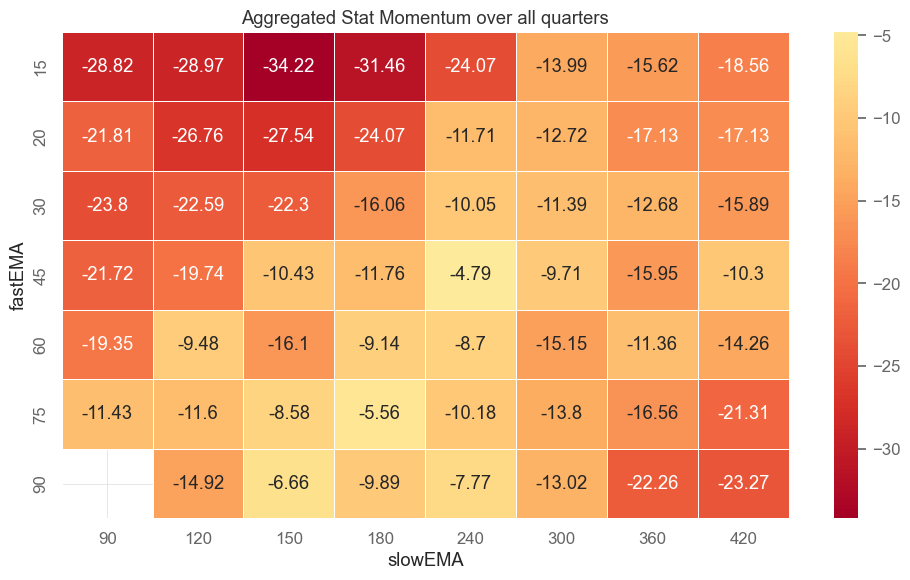

In [49]:
from functions.plot_heatmap import plot_heatmap

plot_heatmap(
    df=aggregated_stats_2MAs,
    value_col='stat_mom_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Momentum over all quarters',
)

Volatility breakout strategy

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create an empty DataFrame to store summary for all quarters
summary_all_breakout = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')

    # Lets set the datetime index
    data1.set_index('datetime', inplace=True)

    # assumption 1
    # do not use in calculations the data from the first and last 10 minutes
    # of the session (9:31-9:40 and 15:51-16:00) – put missing values there,
    data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    # assumption 2
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data1))

    # do not trade within the first 25 minutes of stocks quotations (9:31-9:55),
    pos_flat[data1.index.time <= pd.to_datetime("9:55").time()] = 1

    # do not hold positions overnight (exit all positions 20 minutes
    # before the session end, i.e. at 15:40),
    pos_flat[data1.index.time >= pd.to_datetime("15:40").time()] = 1

    # apply the strategy
    ##############################################################
    SP = data1['SP']

    # create a dataframe to store results
    # loop over different parameter combinations
    for signalEMA in signalEMA_parameters:
        print(f"signalEMA = {signalEMA}")
        for slowEMA in slowEMA_parameters:
            for volat_sd in volat_sd_parameters:
                for m in m_parameters:

                    # We calculate the appropriate EMA
                    signalEMA_values = SP.ewm(span = signalEMA).mean().to_numpy()
                    slowEMA_values = SP.ewm(span = slowEMA).mean().to_numpy()

                    # We calculate the standard deviation
                    volat_sd_values = SP.rolling(window = volat_sd).std().to_numpy()

                    # Insert NaNs wherever the original price is missing
                    signalEMA_values[SP.isna()] = np.nan
                    slowEMA_values[SP.isna()] = np.nan
                    volat_sd_values[SP.isna()] = np.nan

                    # Calculate position for momentum strategy
                    pos_mom = positionVB(signal = signalEMA_values,
                                     lower = slowEMA_values - m * volat_sd_values,
                                     upper = slowEMA_values + m * volat_sd_values,
                                     pos_flat = pos_flat,
                                     strategy = "mom")

                    pos_mr = -pos_mom

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * SP.diff()), 0, pos_mom * SP.diff() * 50)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * SP.diff()), 0, pos_mr * SP.diff() * 50)
                    # point value for SP

                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend = 0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 12  # cost $10 per transaction on SP
                    pnl_net_mr = pnl_gross_mr - ntrans * 12  # cost $10 per transaction on SP

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = SP.index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(SP.index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = SP.index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(SP.index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = SP.index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(SP.index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = SP.index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(SP.index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = SP.index.time
                    ntrans_d = ntrans.groupby(SP.index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()

                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom/1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr/1000)))
                # Collect the necessary results into one object
                    summary = pd.DataFrame({
                    'signalEMA': signalEMA,
                    'slowEMA': slowEMA,
                    'volat_sd': volat_sd,
                    'm': m,
                    'quarter': quarter,
                    'gross_SR_mom': gross_SR_mom,
                    'net_SR_mom': net_SR_mom,
                    'gross_PnL_mom': gross_PnL_mom,
                    'net_PnL_mom': net_PnL_mom,
                    'gross_SR_mr': gross_SR_mr,
                    'net_SR_mr': net_SR_mr,
                    'gross_PnL_mr': gross_PnL_mr,
                    'net_PnL_mr': net_PnL_mr,
                    'av_daily_ntrans': av_daily_ntrans,
                    'stat_mom': stat_mom,
                    'stat_mr': stat_mr
                    }, index=[0])

                # Append the results to the summary
                    summary_all_breakout = pd.concat([summary_all_breakout, summary], ignore_index=True)

Processing quarter: 2023_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q3
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [54]:
summary_all_breakout["signalEMA_slowEMA"] = (
    summary_all_breakout["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout["volat_sd_m"] = (
    summary_all_breakout["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout["m"].astype(str)
)

summary_all_breakout.head()

signalEMA  slowEMA  volat_sd  m  quarter  gross_SR_mom  net_SR_mom  \
0         20       90        60  1  2023_Q1      2.922960    2.380899   
1         20       90        60  2  2023_Q1      0.095930   -0.238286   
2         20       90        60  3  2023_Q1      0.430561    0.156752   
3         20       90        90  1  2023_Q1      2.610015    2.101685   
4         20       90        90  2  2023_Q1      0.756455    0.620577   

   gross_PnL_mom  net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  \
0       15324.10     12612.10    -2.922960  -3.475820     -15324.10   
1         459.85     -1148.15    -0.095930  -0.433509       -459.85   
2        1929.60       705.60    -0.430561  -0.706559      -1929.60   
3       12288.95      9984.95    -2.610015  -3.127219     -12288.95   
4        2535.55      2079.55    -0.756455  -0.892072      -2535.55   

   net_PnL_mr  av_daily_ntrans  stat_mom    stat_mr signalEMA_slowEMA  \
0   -18036.10         3.476923  4.767434 -11.499565           020_090   
1    -2067.85         2.061538 -0.101996  -0.678203           020_090   
2    -3153.60         1.569231 -0.000000  -1.385787           020_090   
3   -14592.95         2.953846  3.685603  -9.722902           020_090   
4    -2991.55         0.584615  0.088281  -1.525421           020_090   

  volat_sd_m  
0      060_1  
1      060_2  
2      060_3  
3      090_1  
4      090_2

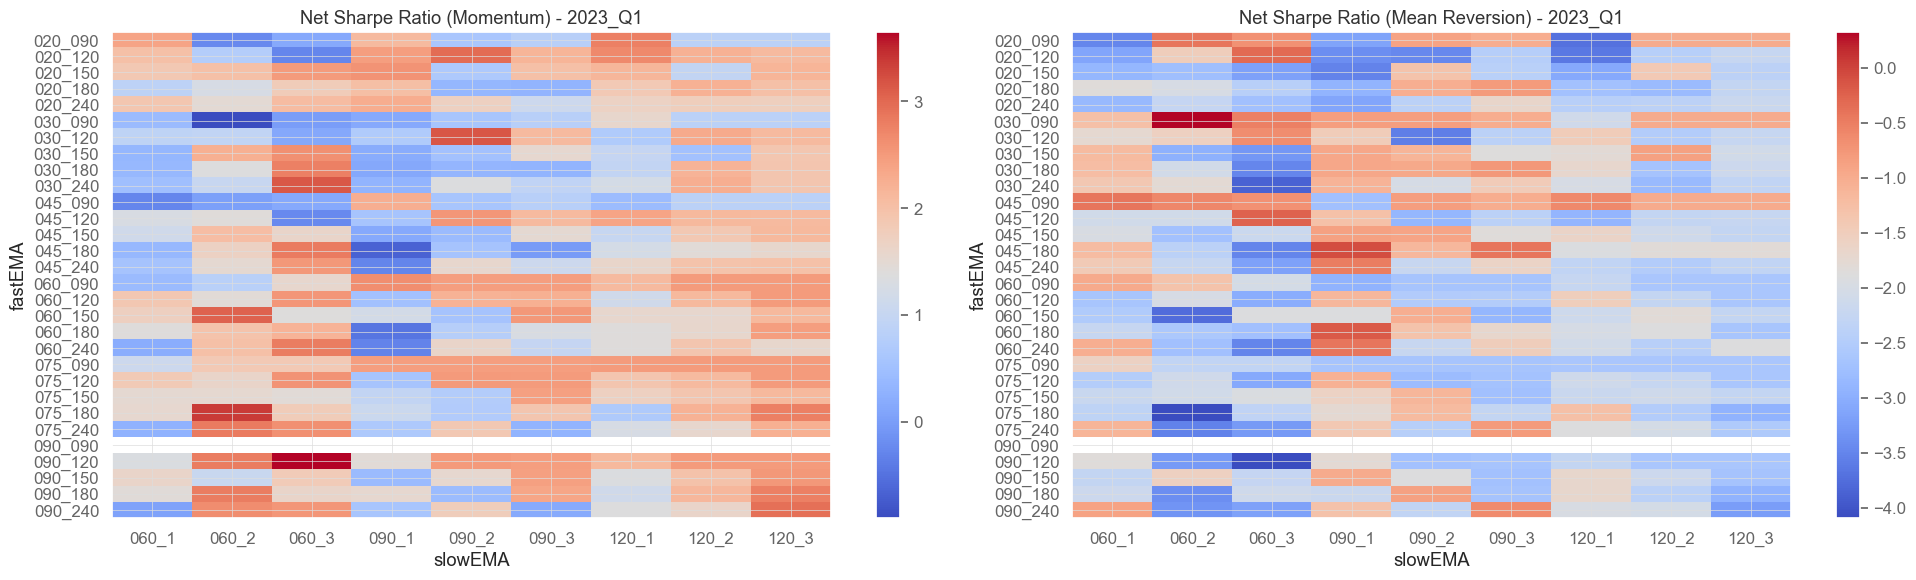

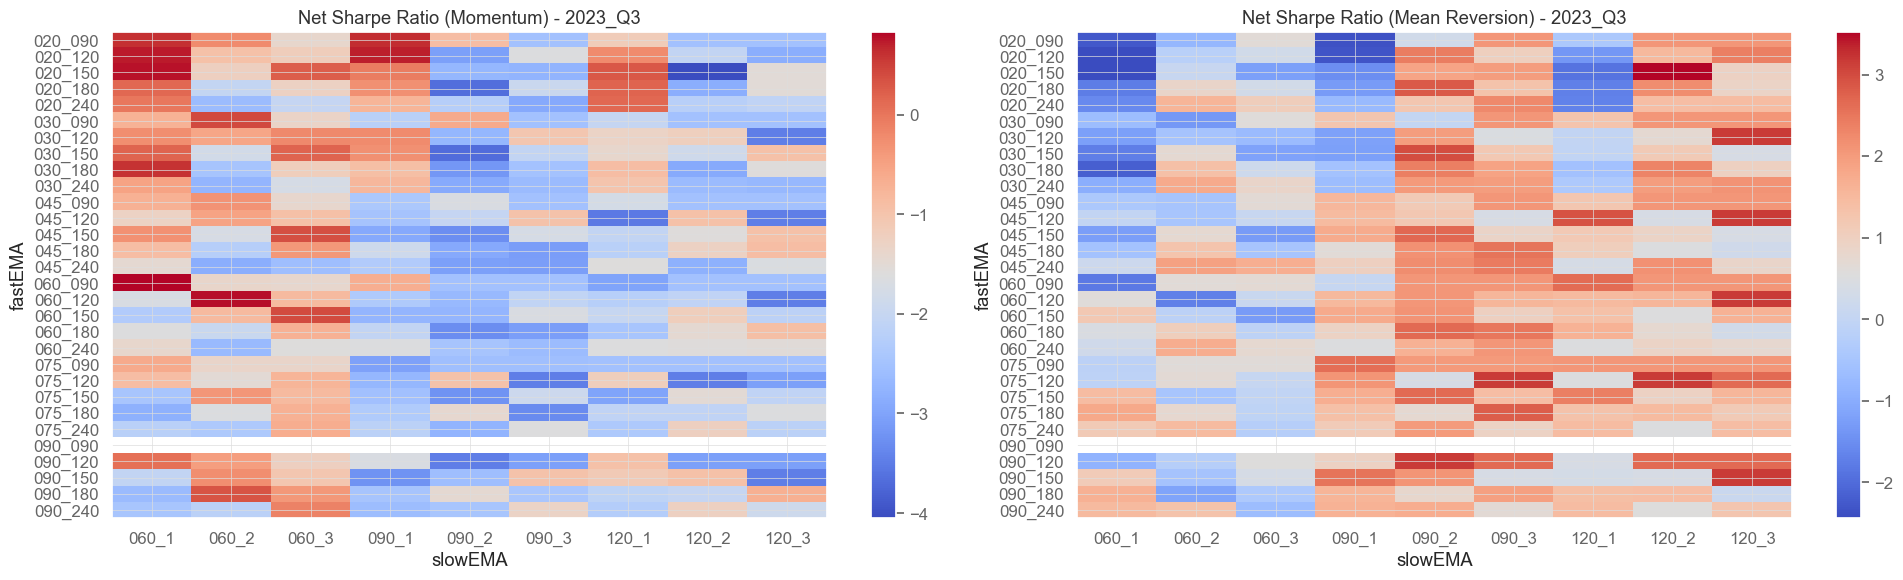

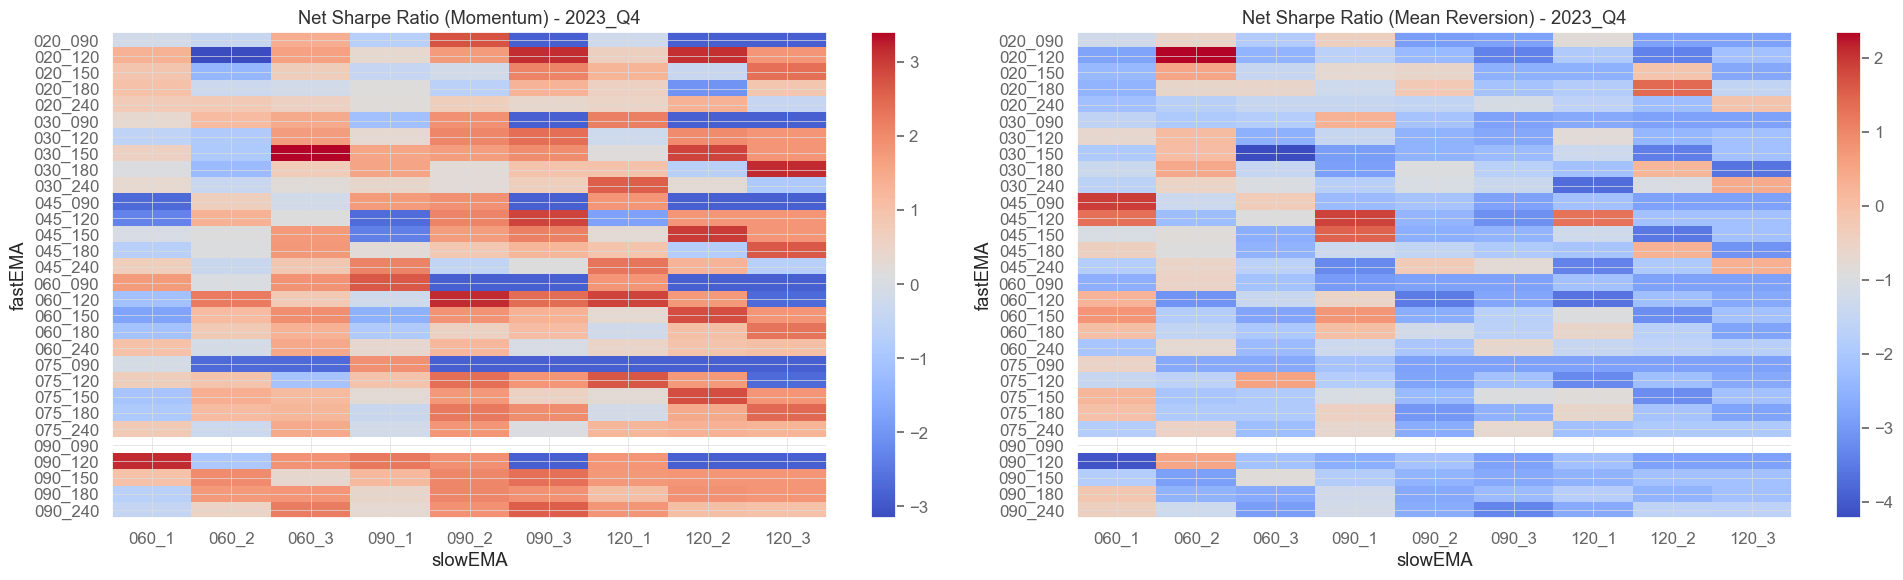

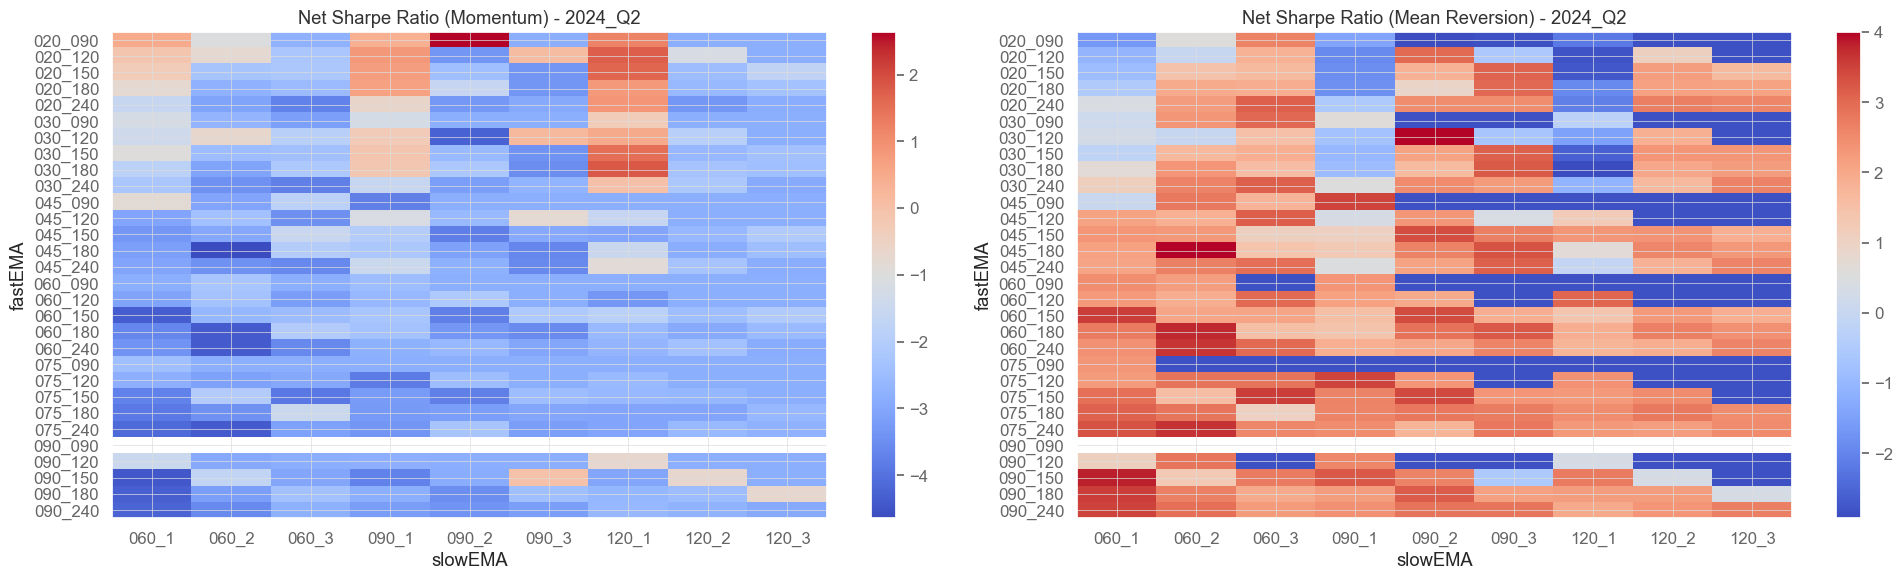

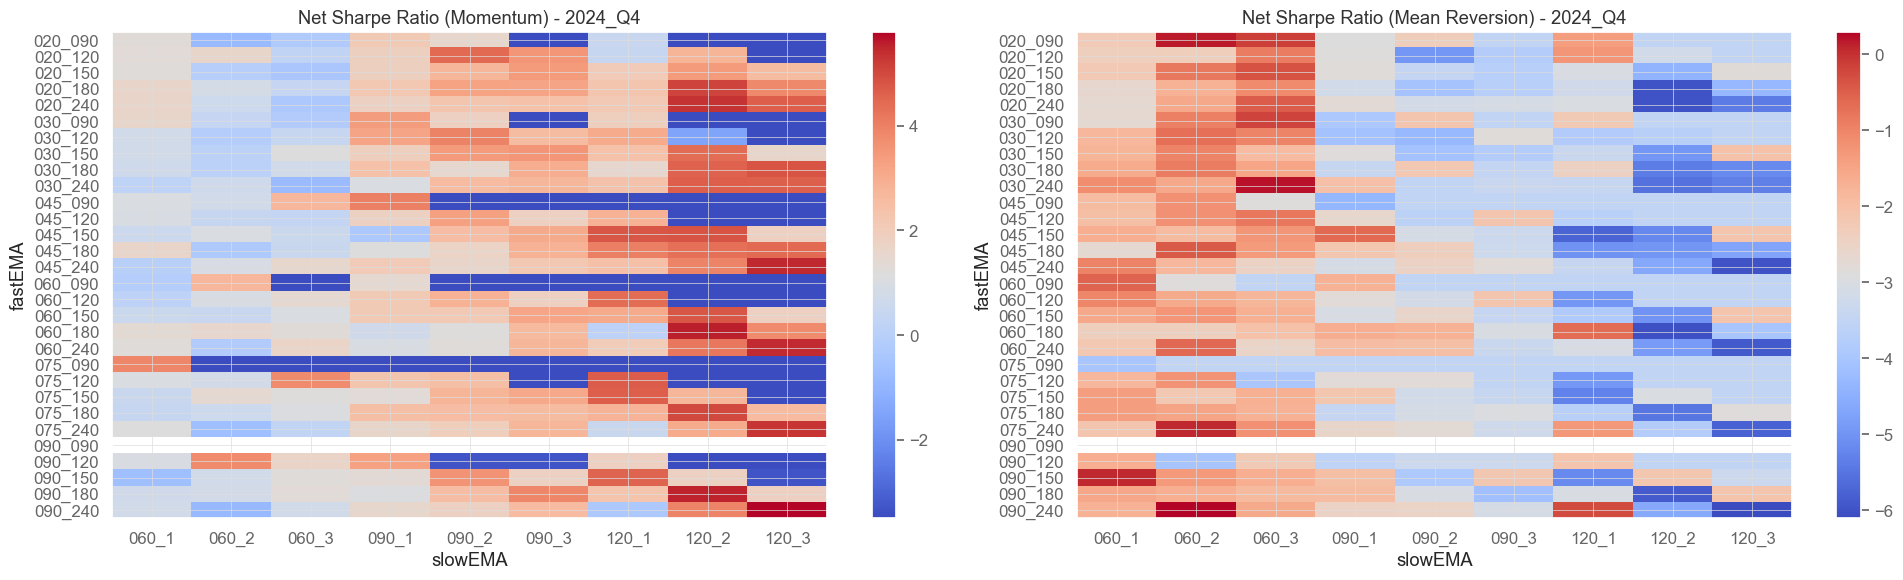

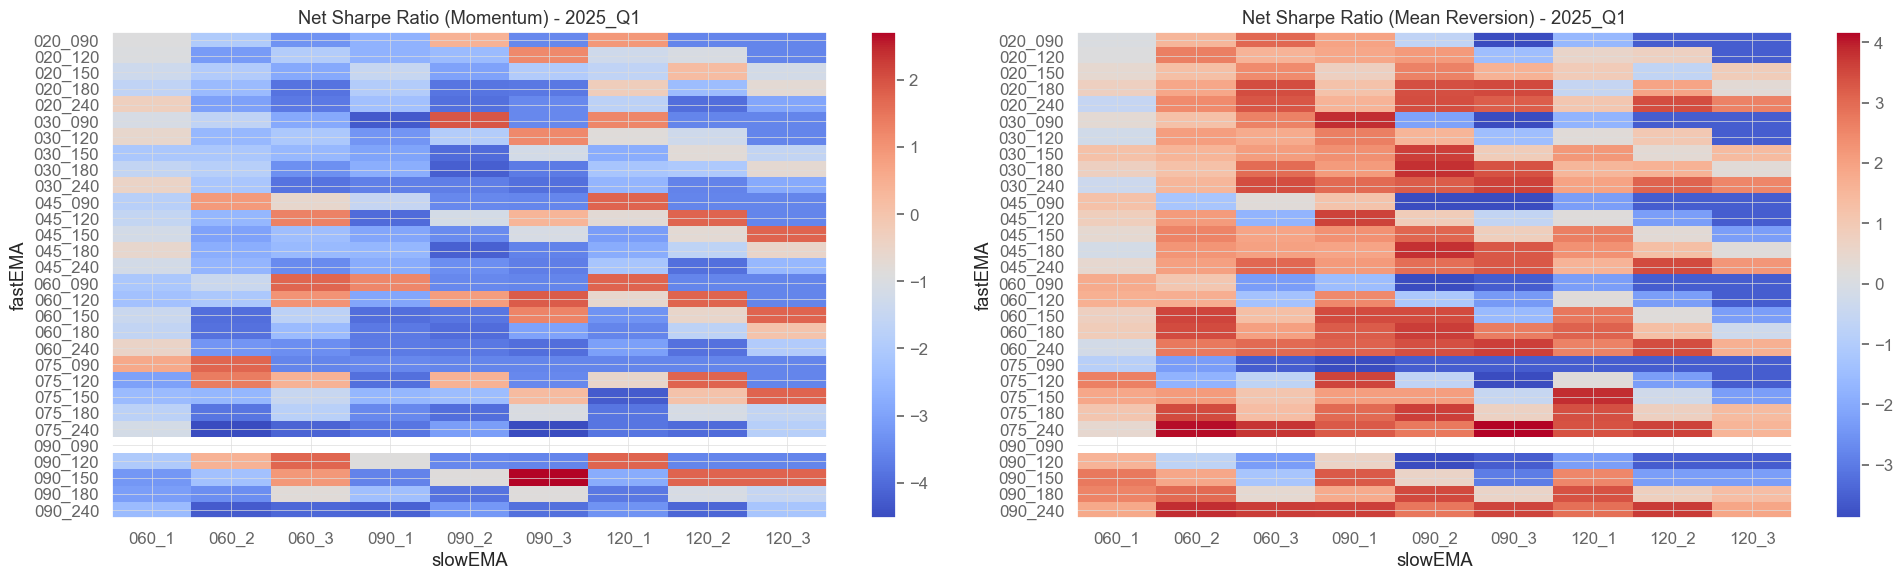

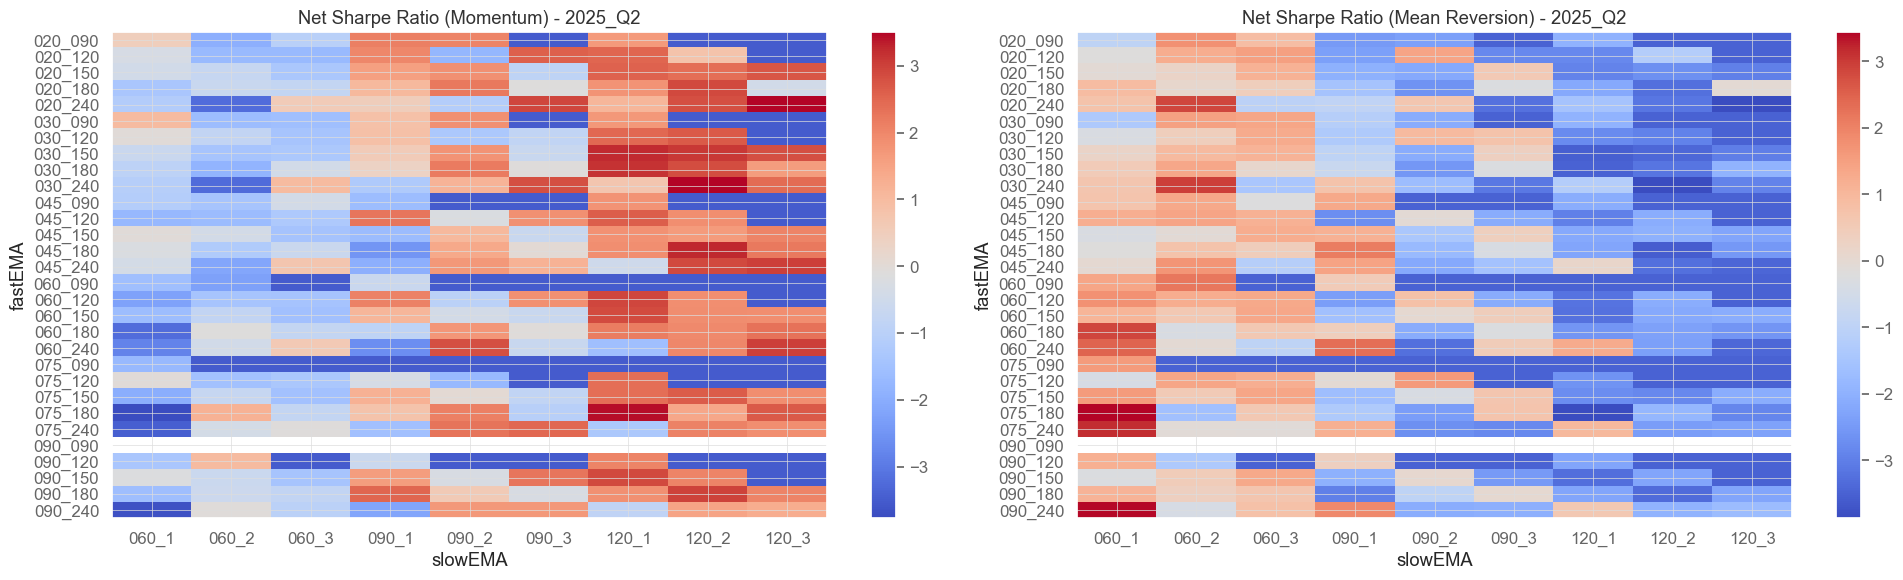

In [55]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_all_breakout[summary_all_breakout['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_SR_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[0].set_title(f'Net Sharpe Ratio (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_SR_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[1].set_title(f'Net Sharpe Ratio (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

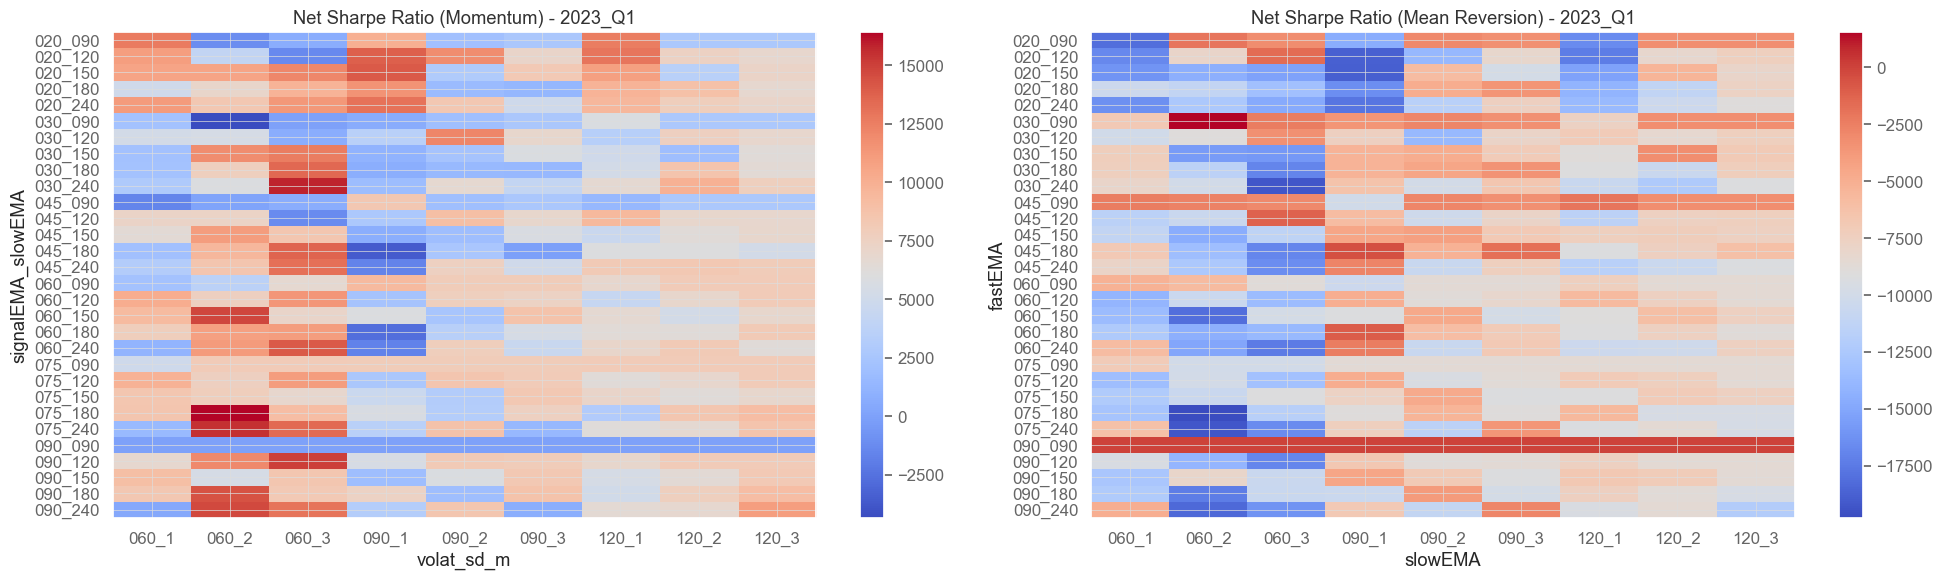

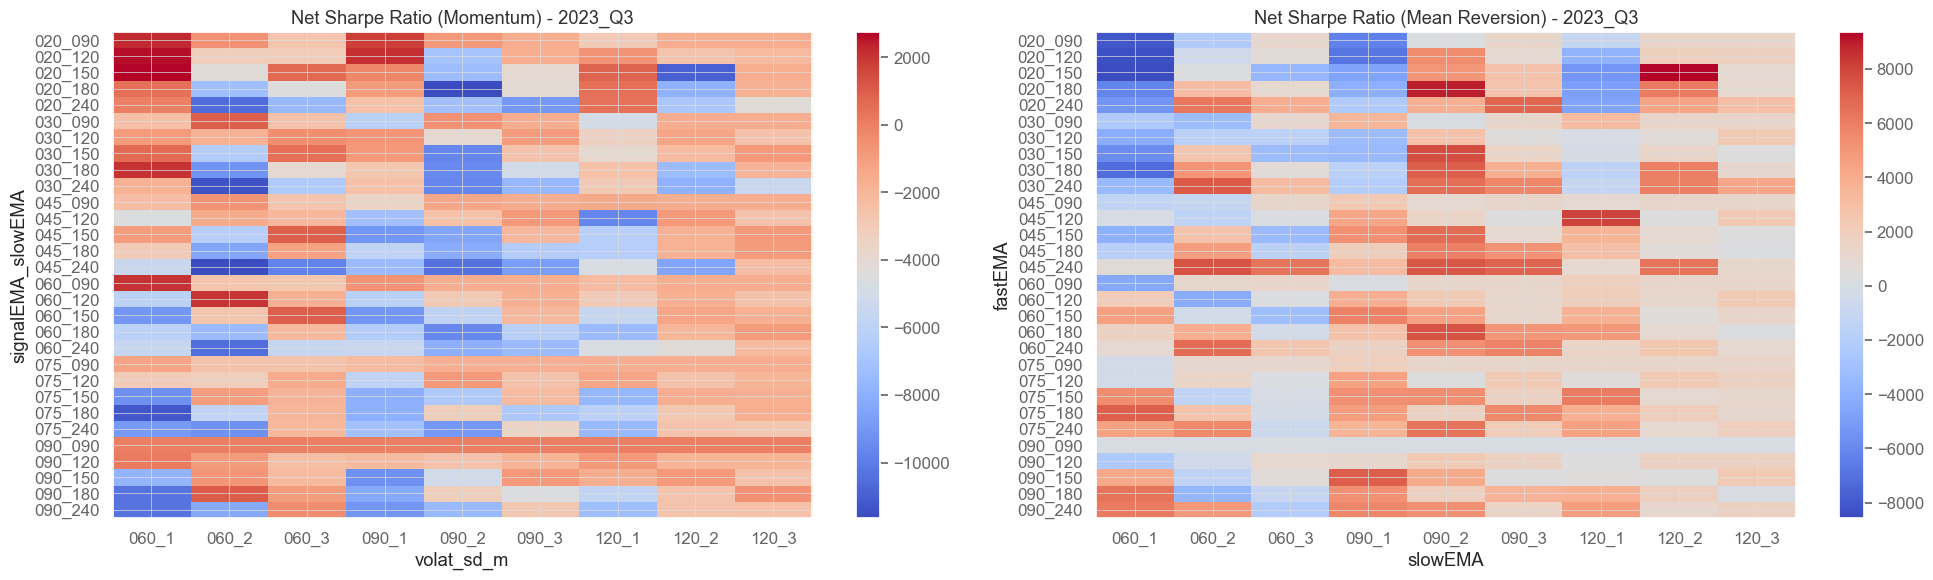

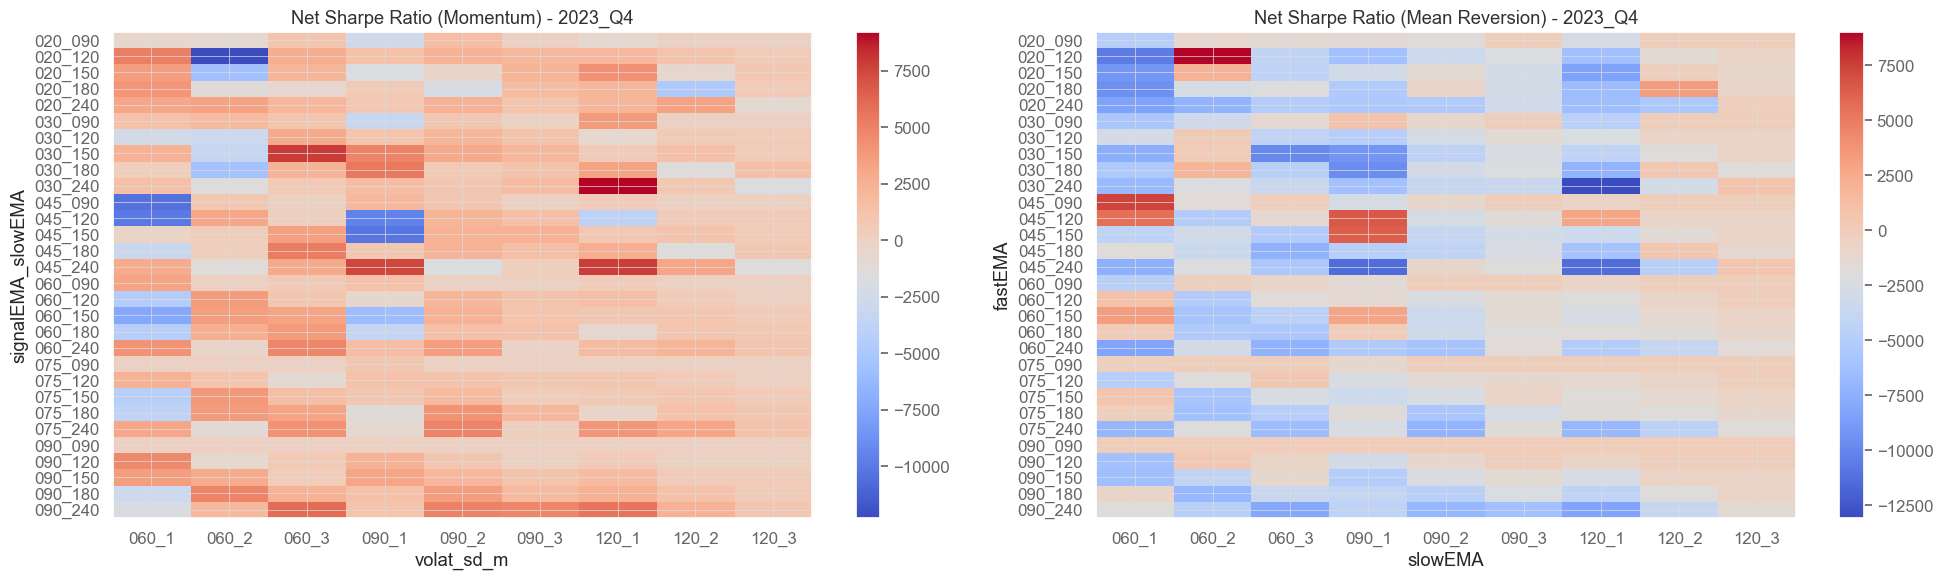

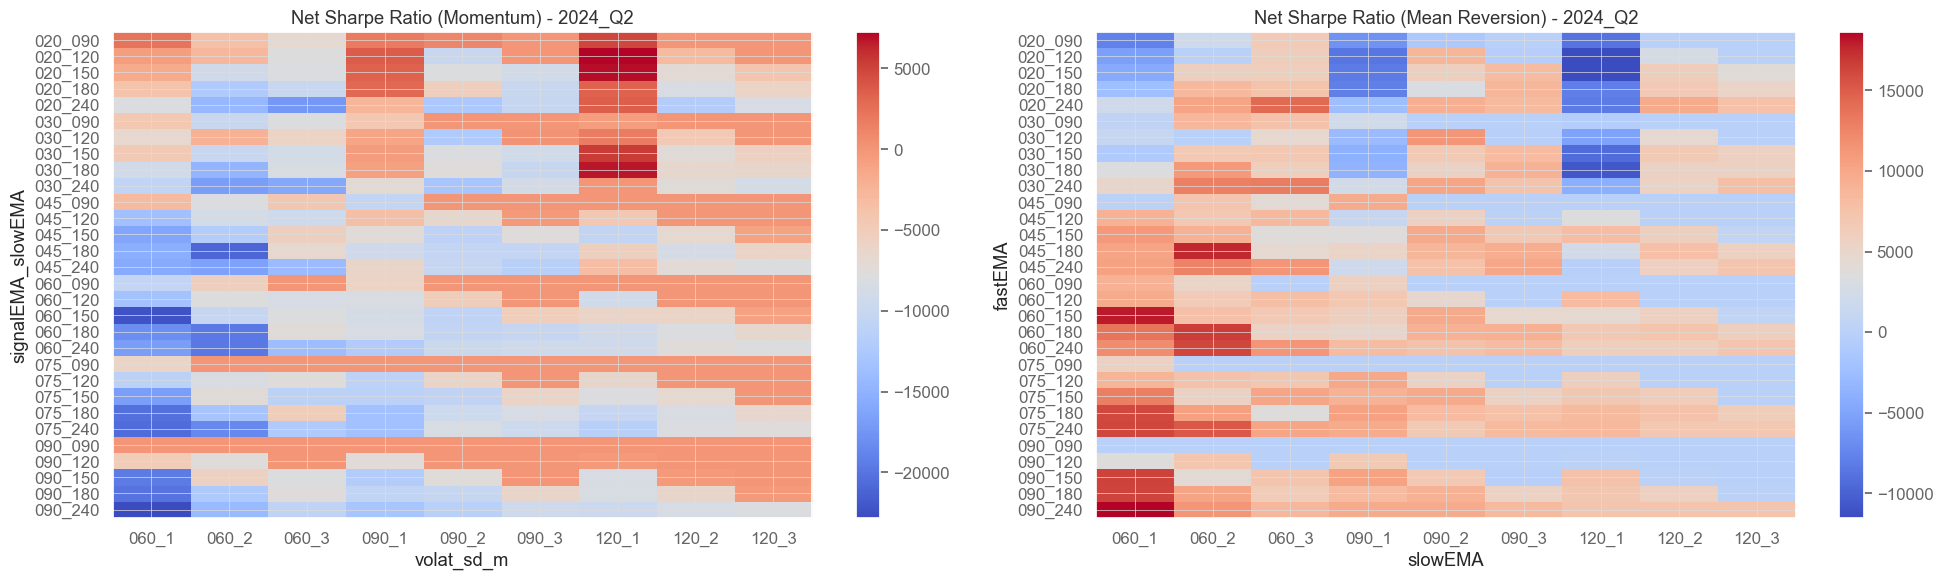

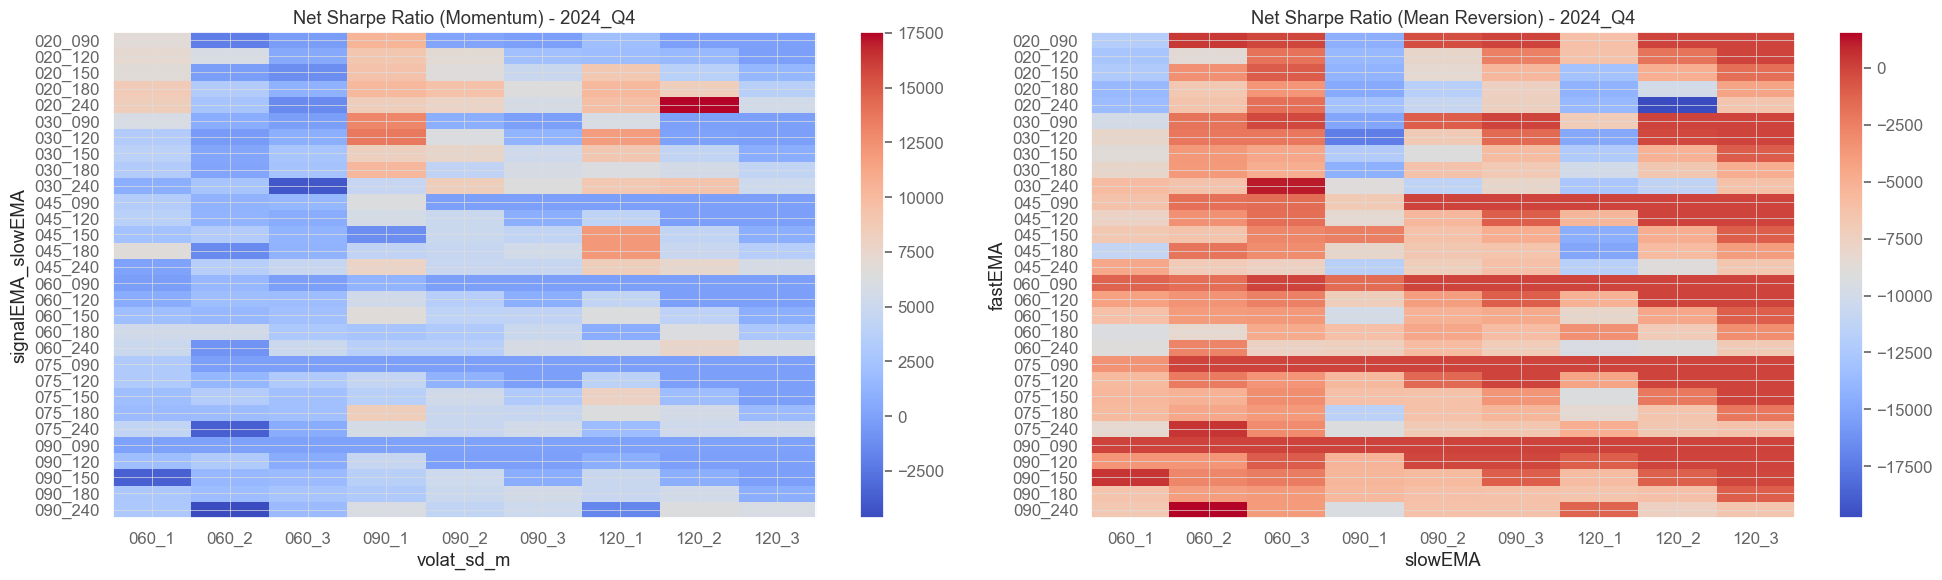

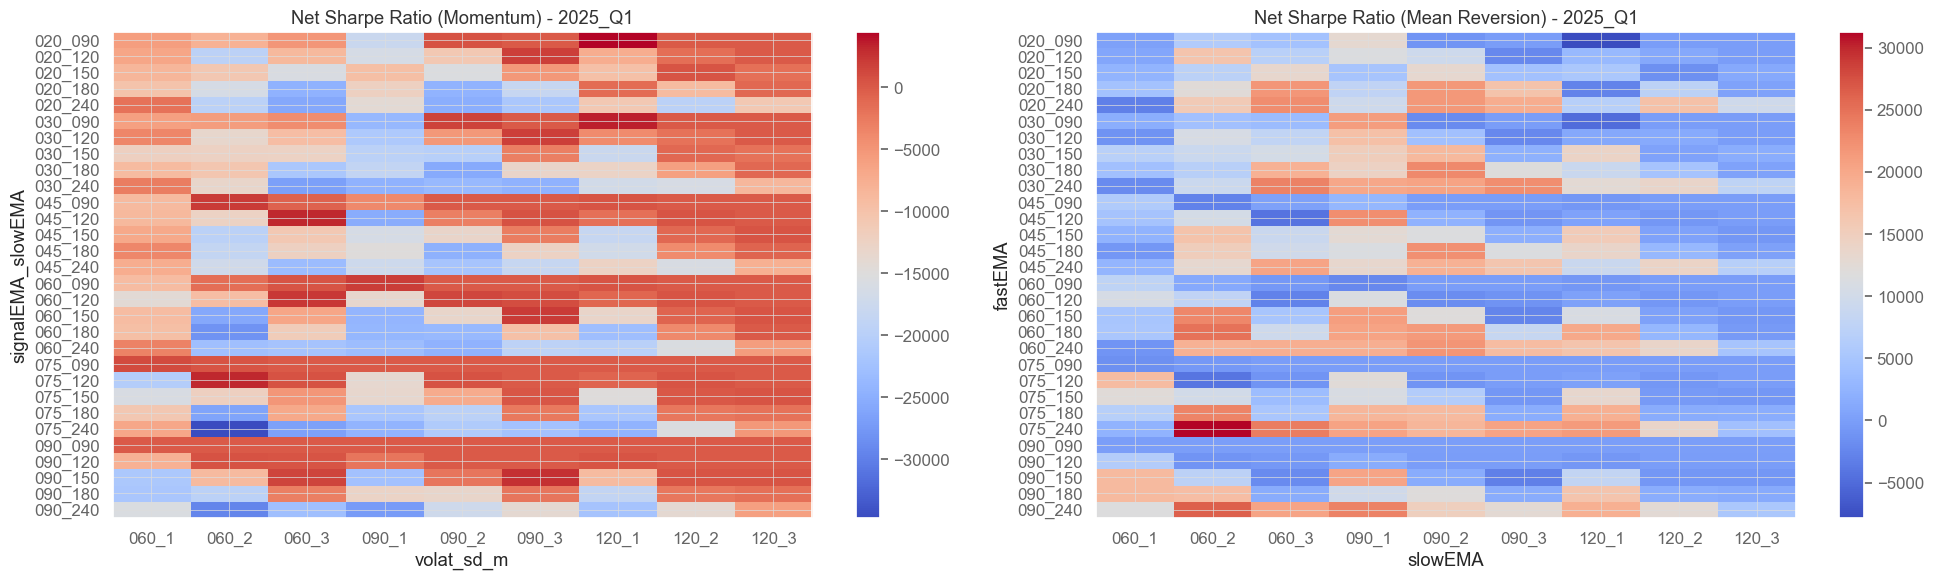

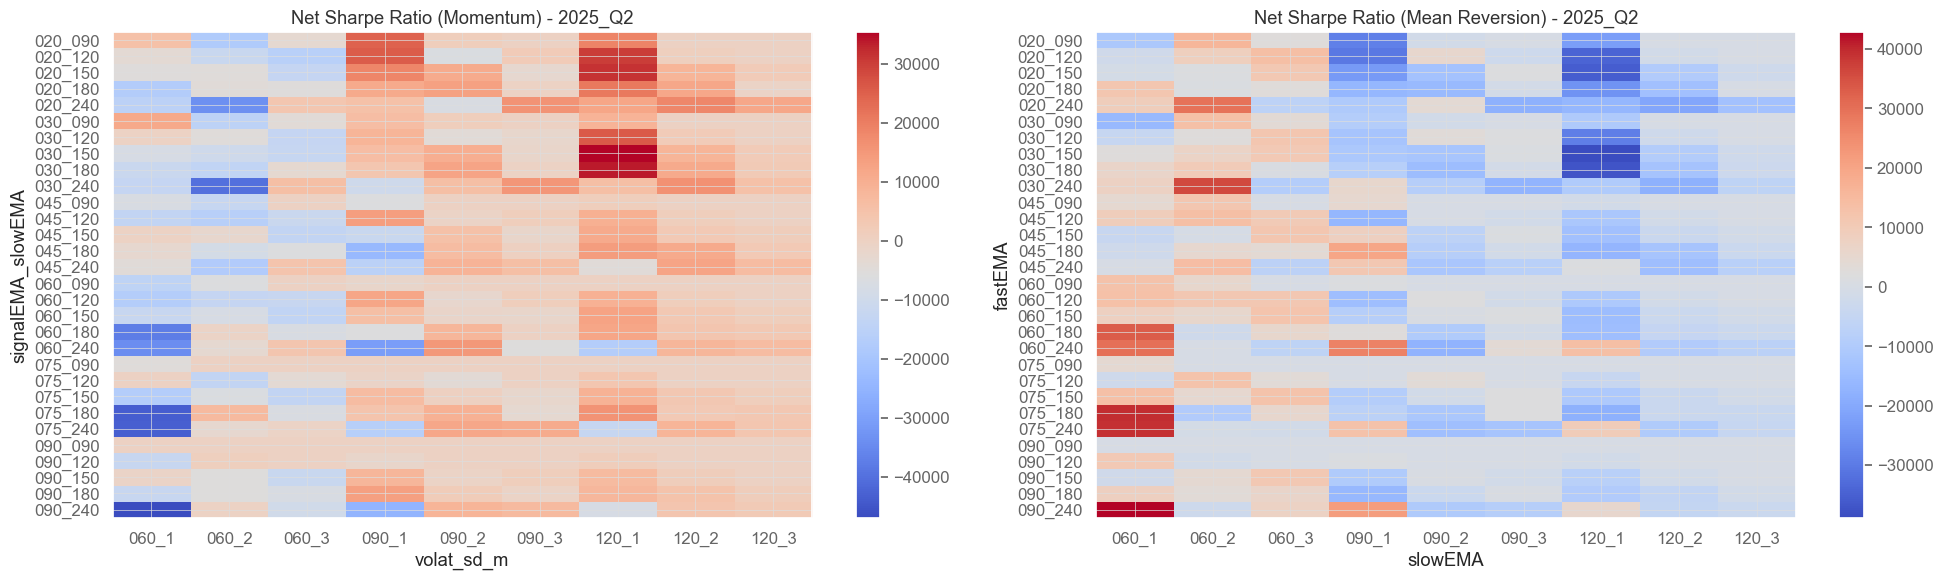

In [58]:
# Create separate heatmaps for each quarter
for quarter in quarters:
    quarter_data = summary_all_breakout[summary_all_breakout['quarter'] == quarter]

    # Create figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot momentum strategy heatmap
    quarter_data_pivot_mom = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_PnL_mom')
    im1 = axes[0].imshow(quarter_data_pivot_mom.values, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(quarter_data_pivot_mom.columns)))
    axes[0].set_yticks(range(len(quarter_data_pivot_mom.index)))
    axes[0].set_xticklabels(quarter_data_pivot_mom.columns)
    axes[0].set_yticklabels(quarter_data_pivot_mom.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[0].set_title(f'Net PnL (Momentum) - {quarter}')
    plt.colorbar(im1, ax=axes[0])

    # Plot mean reversion strategy heatmap
    quarter_data_pivot_mr = quarter_data.pivot(index='signalEMA_slowEMA', columns='volat_sd_m', values='net_PnL_mr')
    im2 = axes[1].imshow(quarter_data_pivot_mr.values, cmap='coolwarm', aspect='auto')
    axes[1].set_xticks(range(len(quarter_data_pivot_mr.columns)))
    axes[1].set_yticks(range(len(quarter_data_pivot_mr.index)))
    axes[1].set_xticklabels(quarter_data_pivot_mr.columns)
    axes[1].set_yticklabels(quarter_data_pivot_mr.index)
    axes[0].set_xlabel('volat_sd_m')
    axes[0].set_ylabel('signalEMA_slowEMA')
    axes[1].set_title(f'Net PnL (Mean Reversion) - {quarter}')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [59]:
aggregated_stats_breakout = (
    summary_all_breakout
    .groupby(['signalEMA_slowEMA', 'volat_sd_m'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

aggregated_stats_breakout['stat_mom_total'] = aggregated_stats_breakout['stat_mom_total'].round(2)
aggregated_stats_breakout['stat_mr_total'] = aggregated_stats_breakout['stat_mr_total'].round(2)


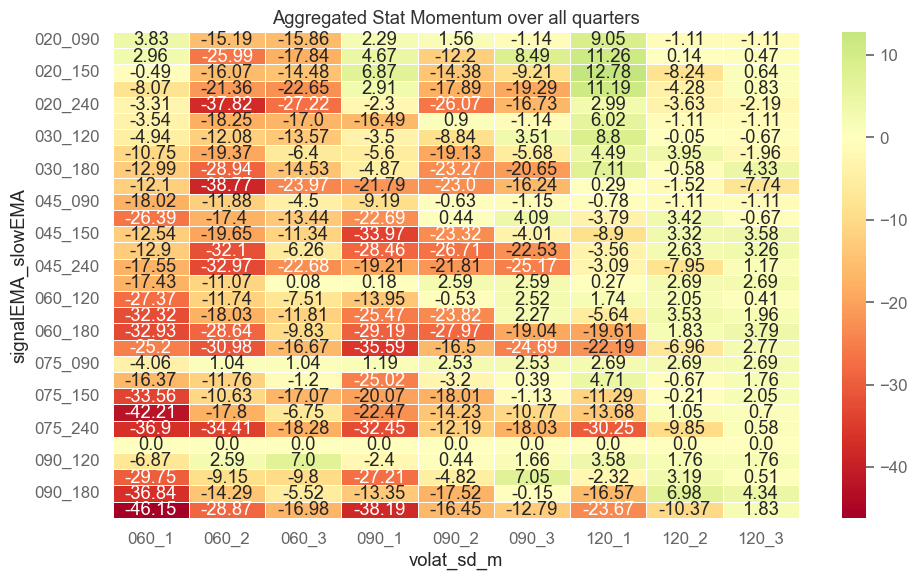

In [61]:
plot_heatmap(
    df=aggregated_stats_breakout,
    value_col='stat_mom_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Momentum over all quarters')

#better, but let's apply some additional conditions

In [ ]:
plot_heatmap(
    df=aggregated_stats_breakout,
    value_col='stat_mr_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Mean Reversion over all quarters')
)

Stop-loss condition

In [62]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


fastEMA_parameters = [15, 20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240, 300, 360, 420]

# create an empty DataFrame to store summary for all quarters
summary_2MAs_stoploss = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')

    # Lets set the datetime index
    data1.set_index('datetime', inplace=True)

    # assumption 1
    # do not use in calculations the data from the first and last 10 minutes
    # of the session (9:31-9:40 and 15:51-16:00) – put missing values there,
    data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    # assumption 2
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data1))

    # do not trade within the first 25 minutes of stocks quotations (9:31-9:55),
    pos_flat[data1.index.time <= pd.to_datetime("9:55").time()] = 1

    # do not hold positions overnight (exit all positions 20 minutes
    # before the session end, i.e. at 15:40),
    pos_flat[data1.index.time >= pd.to_datetime("15:40").time()] = 1

    # apply the strategy
    ##############################################################
    SP = data1['SP']

    for fastEMA in fastEMA_parameters:
        for slowEMA in slowEMA_parameters:

            # ensure that fastEMA is less than slowEMA
            if fastEMA >= slowEMA:
                continue

            print(f"  fastEMA = {fastEMA}, slowEMA = {slowEMA}")

            # We calculate the appropriate EMA
            fastEMA_values = SP.ewm(span=fastEMA).mean()
            slowEMA_values = SP.ewm(span=slowEMA).mean()

            # Insert NaNs wherever the original price is missing
            fastEMA_values[data1['SP'].isna()] = np.nan
            slowEMA_values[data1['SP'].isna()] = np.nan

            # Calculate position for momentum strategy
            cond2b_mom_long = fastEMA_values.shift(1) > slowEMA_values.shift(1)

            # let's add filters that check for the presence of NaN values
            fastEMA_nonmiss = fastEMA_values.shift(1).notna()
            slowEMA_nonmiss = slowEMA_values.shift(1).notna()

            # Now we can add these conditions to our strategies
            # if any of the values is missing,
            # we cannot make a position decision

            pos_mom = np.where(fastEMA_nonmiss & slowEMA_nonmiss,
                               np.where(cond2b_mom_long, 1, -1),
                               np.nan)
            pos_mr = -pos_mom

            # Set position to 0 where pos_flat is 1
            pos_mom[pos_flat == 1] = 0
            pos_mr[pos_flat == 1] = 0

            # Calculate gross pnl
            pnl_gross_mom = np.where(np.isnan(pos_mom * data1["SP"].diff()), 0, pos_mom * data1["SP"].diff() * 50)
            pnl_gross_mr = np.where(np.isnan(pos_mr * data1["SP"].diff()), 0, pos_mr * data1["SP"].diff() * 50)
            # point value for SP

            # Add stop loss condition
                    # Calculate cumulative PnL for each day and apply stop loss
            pnl_gross_mom_series = pd.Series(pnl_gross_mom, index=data1.index)
            pnl_gross_mr_series = pd.Series(pnl_gross_mr, index=data1.index)

            # Define stop loss threshold (e.g., -1000 per day)
            stop_loss_threshold = -500

            # Calculate cumulative daily PnL
            daily_cumul_pnl_mom = pnl_gross_mom_series.groupby(data1.index.date).cumsum()
            daily_cumul_pnl_mr = pnl_gross_mr_series.groupby(data1.index.date).cumsum()

            # Create stop loss mask (stop trading for rest of day if threshold hit)
            stop_loss_triggered_mom = (daily_cumul_pnl_mom <= stop_loss_threshold).groupby(data1.index.date).cummax()
            stop_loss_triggered_mr = (daily_cumul_pnl_mr <= stop_loss_threshold).groupby(data1.index.date).cummax()

            # Apply stop loss by setting position to 0 after trigger
            pos_mom_sl = pos_mom.copy()
            pos_mom_sl[stop_loss_triggered_mom] = 0
            pos_mr_sl = pos_mr.copy()
            pos_mr_sl[stop_loss_triggered_mr] = 0

            # Recalculate PnL with stop loss
            pnl_gross_mom = np.where(np.isnan(pos_mom_sl * data1['SP'].diff()), 0, pos_mom_sl * data1['SP'].diff() * 50)
            pnl_gross_mr = np.where(np.isnan(pos_mr_sl * data1['SP'].diff()), 0, pos_mr_sl * data1['SP'].diff() * 50)

            # Calculate number of transactions
            ntrans = np.abs(np.diff(pos_mom, prepend=0))

            # Calculate net pnl
            pnl_net_mom = pnl_gross_mom - ntrans * 12  # cost $12 per transaction
            pnl_net_mr = pnl_gross_mr - ntrans * 12  # cost $12 per transaction

            # Aggregate to daily data
            pnl_gross_mom = pd.Series(pnl_gross_mom)
            pnl_gross_mom.index = data1['SP'].index.time
            pnl_gross_mom_d = pnl_gross_mom.groupby(data1['SP'].index.date).sum()
            pnl_gross_mr = pd.Series(pnl_gross_mr)
            pnl_gross_mr.index = data1['SP'].index.time
            pnl_gross_mr_d = pnl_gross_mr.groupby(data1['SP'].index.date).sum()

            pnl_net_mom = pd.Series(pnl_net_mom)
            pnl_net_mom.index = data1['SP'].index.time
            pnl_net_mom_d = pnl_net_mom.groupby(data1['SP'].index.date).sum()
            pnl_net_mr = pd.Series(pnl_net_mr)
            pnl_net_mr.index = data1['SP'].index.time
            pnl_net_mr_d = pnl_net_mr.groupby(data1['SP'].index.date).sum()

            ntrans = pd.Series(ntrans)
            ntrans.index = data1['SP'].index.time
            ntrans_d = ntrans.groupby(data1['SP'].index.date).sum()

            # Calculate Sharpe Ratio and PnL
            gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
            net_SR_mom = mySR(pnl_net_mom_d, scale=252)
            gross_PnL_mom = pnl_gross_mom_d.sum()
            net_PnL_mom = pnl_net_mom_d.sum()
            gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
            net_SR_mr = mySR(pnl_net_mr_d, scale=252)
            gross_PnL_mr = pnl_gross_mr_d.sum()
            net_PnL_mr = pnl_net_mr_d.sum()

            av_daily_ntrans = ntrans_d.mean()
            stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom / 1000)))
            stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr / 1000)))

            # Collect necessary results into one object
            summary = pd.DataFrame({
                'fastEMA': fastEMA,
                'slowEMA': slowEMA,
                'quarter': quarter,
                'gross_SR_mom': gross_SR_mom,
                'net_SR_mom': net_SR_mom,
                'gross_PnL_mom': gross_PnL_mom,
                'net_PnL_mom': net_PnL_mom,
                'gross_SR_mr': gross_SR_mr,
                'net_SR_mr': net_SR_mr,
                'gross_PnL_mr': gross_PnL_mr,
                'net_PnL_mr': net_PnL_mr,
                'av_daily_ntrans': av_daily_ntrans,
                'stat_mom': stat_mom,
                'stat_mr': stat_mr
            }, index=[0])

            # Append results to the summary
            summary_2MAs_stoploss = pd.concat([summary_2MAs_stoploss, summary], ignore_index=True)

Processing quarter: 2023_Q1
  fastEMA = 15, slowEMA = 90
  fastEMA = 15, slowEMA = 120
  fastEMA = 15, slowEMA = 150
  fastEMA = 15, slowEMA = 180
  fastEMA = 15, slowEMA = 240
  fastEMA = 15, slowEMA = 300
  fastEMA = 15, slowEMA = 360
  fastEMA = 15, slowEMA = 420
  fastEMA = 20, slowEMA = 90
  fastEMA = 20, slowEMA = 120
  fastEMA = 20, slowEMA = 150
  fastEMA = 20, slowEMA = 180
  fastEMA = 20, slowEMA = 240
  fastEMA = 20, slowEMA = 300
  fastEMA = 20, slowEMA = 360
  fastEMA = 20, slowEMA = 420
  fastEMA = 30, slowEMA = 90
  fastEMA = 30, slowEMA = 120
  fastEMA = 30, slowEMA = 150
  fastEMA = 30, slowEMA = 180
  fastEMA = 30, slowEMA = 240
  fastEMA = 30, slowEMA = 300
  fastEMA = 30, slowEMA = 360
  fastEMA = 30, slowEMA = 420
  fastEMA = 45, slowEMA = 90
  fastEMA = 45, slowEMA = 120
  fastEMA = 45, slowEMA = 150
  fastEMA = 45, slowEMA = 180
  fastEMA = 45, slowEMA = 240
  fastEMA = 45, slowEMA = 300
  fastEMA = 45, slowEMA = 360
  fastEMA = 45, slowEMA = 420
  fastEMA = 60, 

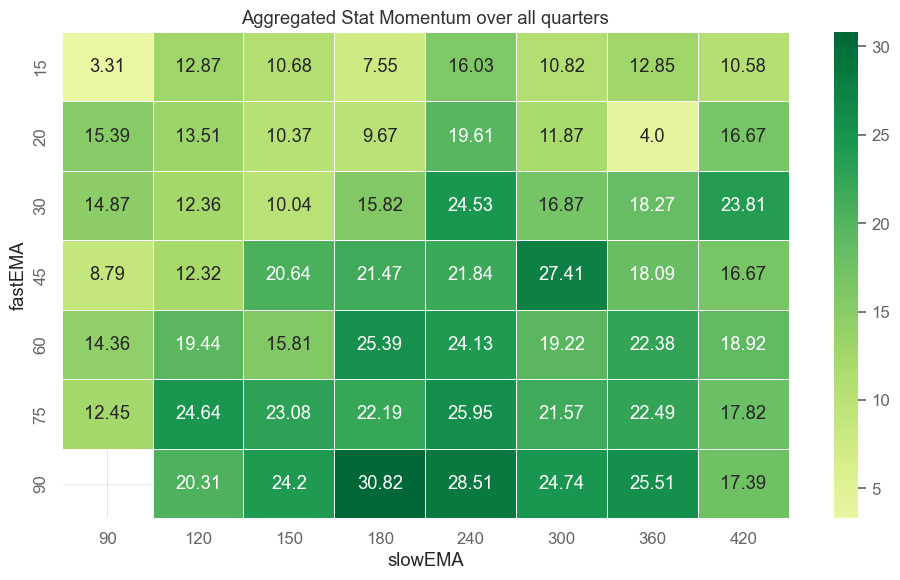

In [63]:
aggregated_stats_2MAs_stoploss = (
    summary_2MAs_stoploss
    .groupby(['fastEMA', 'slowEMA'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

aggregated_stats_2MAs_stoploss['stat_mom_total'] = aggregated_stats_2MAs_stoploss['stat_mom_total'].round(2)
aggregated_stats_2MAs_stoploss['stat_mr_total'] = aggregated_stats_2MAs_stoploss['stat_mr_total'].round(2)

plot_heatmap(
    df=aggregated_stats_2MAs_stoploss,
    value_col='stat_mom_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Momentum over all quarters')

#a lot better


In [ ]:
plot_heatmap(
    df=aggregated_stats_2MAs_stoploss,
    value_col='stat_mr_total',
    index_col='fastEMA',
    columns_col='slowEMA',
    title='Aggregated Stat Mean Reversion over all quarters')
)

In [64]:
def mySR(x, scale):
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


signalEMA_parameters = [20, 30, 45, 60, 75, 90]
slowEMA_parameters = [90, 120, 150, 180, 240]
volat_sd_parameters = [60, 90, 120]
m_parameters = [1, 2, 3]

# create an empty DataFrame to store summary for all quarters
summary_all_breakout_stoploss = pd.DataFrame()

for quarter in quarters:

    print(f'Processing quarter: {quarter}')

    data1 = pd.read_parquet(f'data/data1_{quarter}.parquet')

    # Lets set the datetime index
    data1.set_index('datetime', inplace=True)

    # assumption 1
    # do not use in calculations the data from the first and last 10 minutes
    # of the session (9:31-9:40 and 15:51-16:00) – put missing values there,
    data1.loc[data1.between_time("9:31", "9:40").index] = np.nan
    data1.loc[data1.between_time("15:51", "16:00").index] = np.nan

    # assumption 2
    # let's create an object named "pos_flat"
    # = 1 if position has to be flat (= 0) - we do not trade
    # = 0 otherwise

    # let's fill it first with zeros
    pos_flat = np.zeros(len(data1))

    # do not trade within the first 25 minutes of stocks quotations (9:31-9:55),
    pos_flat[data1.index.time <= pd.to_datetime("9:55").time()] = 1

    # do not hold positions overnight (exit all positions 20 minutes
    # before the session end, i.e. at 15:40),
    pos_flat[data1.index.time >= pd.to_datetime("15:40").time()] = 1

    # apply the strategy
    ##############################################################
    SP = data1['SP']

    # create a dataframe to store results
    # loop over different parameter combinations
    for signalEMA in signalEMA_parameters:
        print(f"signalEMA = {signalEMA}")
        for slowEMA in slowEMA_parameters:
            for volat_sd in volat_sd_parameters:
                for m in m_parameters:
                    # We calculate the appropriate EMA
                    signalEMA_values = SP.ewm(span=signalEMA).mean().to_numpy()
                    slowEMA_values = SP.ewm(span=slowEMA).mean().to_numpy()

                    # We calculate the standard deviation
                    volat_sd_values = SP.rolling(window=volat_sd).std().to_numpy()

                    # Insert NaNs wherever the original price is missing
                    signalEMA_values[SP.isna()] = np.nan
                    slowEMA_values[SP.isna()] = np.nan
                    volat_sd_values[SP.isna()] = np.nan

                    # Calculate position for momentum strategy
                    pos_mom = positionVB(signal=signalEMA_values,
                                         lower=slowEMA_values - m * volat_sd_values,
                                         upper=slowEMA_values + m * volat_sd_values,
                                         pos_flat=pos_flat,
                                         strategy="mom")

                    pos_mr = -pos_mom

                    # Calculate gross pnl
                    pnl_gross_mom = np.where(np.isnan(pos_mom * SP.diff()), 0, pos_mom * SP.diff() * 50)
                    pnl_gross_mr = np.where(np.isnan(pos_mr * SP.diff()), 0, pos_mr * SP.diff() * 50)
                    # point value for SP

                     # Add stop loss condition
                    # Calculate cumulative PnL for each day and apply stop loss
                    pnl_gross_mom_series = pd.Series(pnl_gross_mom, index=data1.index)
                    pnl_gross_mr_series = pd.Series(pnl_gross_mr, index=data1.index)

                    # Define stop loss threshold (e.g., -1000 per day)
                    stop_loss_threshold = -500

                    # Calculate cumulative daily PnL
                    daily_cumul_pnl_mom = pnl_gross_mom_series.groupby(data1.index.date).cumsum()
                    daily_cumul_pnl_mr = pnl_gross_mr_series.groupby(data1.index.date).cumsum()

                    # Create stop loss mask (stop trading for rest of day if threshold hit)
                    stop_loss_triggered_mom = (daily_cumul_pnl_mom <= stop_loss_threshold).groupby(data1.index.date).cummax()
                    stop_loss_triggered_mr = (daily_cumul_pnl_mr <= stop_loss_threshold).groupby(data1.index.date).cummax()

                    # Apply stop loss by setting position to 0 after trigger
                    pos_mom_sl = pos_mom.copy()
                    pos_mom_sl[stop_loss_triggered_mom] = 0
                    pos_mr_sl = pos_mr.copy()
                    pos_mr_sl[stop_loss_triggered_mr] = 0

                    # Recalculate PnL with stop loss
                    pnl_gross_mom = np.where(np.isnan(pos_mom_sl * data1['SP'].diff()), 0, pos_mom_sl * data1['SP'].diff() * 50)
                    pnl_gross_mr = np.where(np.isnan(pos_mr_sl * data1['SP'].diff()), 0, pos_mr_sl * data1['SP'].diff() * 50)
                    # Calculate number of transactions
                    ntrans = np.abs(np.diff(pos_mom, prepend=0))

                    # Calculate net pnl
                    pnl_net_mom = pnl_gross_mom - ntrans * 12  # cost $10 per transaction on SP
                    pnl_net_mr = pnl_gross_mr - ntrans * 12  # cost $10 per transaction on SP

                    # Aggregate to daily data
                    pnl_gross_mom = pd.Series(pnl_gross_mom)
                    pnl_gross_mom.index = SP.index.time
                    pnl_gross_mom_d = pnl_gross_mom.groupby(SP.index.date).sum()
                    pnl_gross_mr = pd.Series(pnl_gross_mr)
                    pnl_gross_mr.index = SP.index.time
                    pnl_gross_mr_d = pnl_gross_mr.groupby(SP.index.date).sum()

                    pnl_net_mom = pd.Series(pnl_net_mom)
                    pnl_net_mom.index = SP.index.time
                    pnl_net_mom_d = pnl_net_mom.groupby(SP.index.date).sum()
                    pnl_net_mr = pd.Series(pnl_net_mr)
                    pnl_net_mr.index = SP.index.time
                    pnl_net_mr_d = pnl_net_mr.groupby(SP.index.date).sum()

                    ntrans = pd.Series(ntrans)
                    ntrans.index = SP.index.time
                    ntrans_d = ntrans.groupby(SP.index.date).sum()

                    # Calculate Sharpe Ratio and PnL
                    gross_SR_mom = mySR(pnl_gross_mom_d, scale=252)
                    net_SR_mom = mySR(pnl_net_mom_d, scale=252)
                    gross_PnL_mom = pnl_gross_mom_d.sum()
                    net_PnL_mom = pnl_net_mom_d.sum()
                    gross_SR_mr = mySR(pnl_gross_mr_d, scale=252)
                    net_SR_mr = mySR(pnl_net_mr_d, scale=252)
                    gross_PnL_mr = pnl_gross_mr_d.sum()
                    net_PnL_mr = pnl_net_mr_d.sum()

                    av_daily_ntrans = ntrans_d.mean()

                    stat_mom = (net_SR_mom - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mom / 1000)))
                    stat_mr = (net_SR_mr - 0.5) * np.maximum(0, np.log(np.abs(net_PnL_mr / 1000)))
                    # Collect the necessary results into one object
                    summary = pd.DataFrame({
                        'signalEMA': signalEMA,
                        'slowEMA': slowEMA,
                        'volat_sd': volat_sd,
                        'm': m,
                        'quarter': quarter,
                        'gross_SR_mom': gross_SR_mom,
                        'net_SR_mom': net_SR_mom,
                        'gross_PnL_mom': gross_PnL_mom,
                        'net_PnL_mom': net_PnL_mom,
                        'gross_SR_mr': gross_SR_mr,
                        'net_SR_mr': net_SR_mr,
                        'gross_PnL_mr': gross_PnL_mr,
                        'net_PnL_mr': net_PnL_mr,
                        'av_daily_ntrans': av_daily_ntrans,
                        'stat_mom': stat_mom,
                        'stat_mr': stat_mr
                    }, index=[0])

                    # Append the results to the summary
                    summary_all_breakout_stoploss = pd.concat([summary_all_breakout_stoploss, summary], ignore_index=True)

Processing quarter: 2023_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q3
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2023_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2024_Q4
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q1
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90
Processing quarter: 2025_Q2
signalEMA = 20
signalEMA = 30
signalEMA = 45
signalEMA = 60
signalEMA = 75
signalEMA = 90


In [65]:
summary_all_breakout_stoploss["signalEMA_slowEMA"] = (
    summary_all_breakout_stoploss["signalEMA"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout_stoploss["slowEMA"].astype(int).astype(str).str.zfill(3)
)

summary_all_breakout_stoploss["volat_sd_m"] = (
    summary_all_breakout_stoploss["volat_sd"].astype(int).astype(str).str.zfill(3) + "_" +
    summary_all_breakout_stoploss["m"].astype(str)
)

summary_all_breakout_stoploss.head()

signalEMA  slowEMA  volat_sd  m  quarter  gross_SR_mom  net_SR_mom  \
0         20       90        60  1  2023_Q1      5.597734    4.790496   
1         20       90        60  2  2023_Q1      4.925083    4.384442   
2         20       90        60  3  2023_Q1      4.726284    4.300134   
3         20       90        90  1  2023_Q1      3.983988    3.326339   
4         20       90        90  2  2023_Q1      3.771112    3.620607   

   gross_PnL_mom  net_PnL_mom  gross_SR_mr  net_SR_mr  gross_PnL_mr  \
0        20240.9      17528.9     1.145613   0.312409       3708.40   
1        14999.0      13391.0     3.224771   2.762282      10685.55   
2        13535.7      12311.7     3.511383   3.140370      10696.50   
3        14454.9      12150.9     0.764285  -0.069736       2113.75   
4         9925.2       9469.2     2.932748   2.725556       5847.30   

   net_PnL_mr  av_daily_ntrans   stat_mom   stat_mr signalEMA_slowEMA  \
0      996.40         3.476923  12.287340 -0.000000           020_090   
1     9077.55         2.061538  10.078506  4.990152           020_090   
2     9472.50         1.569231   9.540425  5.936590           020_090   
3     -190.25         2.953846   7.058509 -0.000000           020_090   
4     5391.30         0.584615   7.015262  3.749587           020_090   

  volat_sd_m  
0      060_1  
1      060_2  
2      060_3  
3      090_1  
4      090_2

In [66]:
aggregated_stats_breakout_stoploss = (
    summary_all_breakout_stoploss
    .groupby(['signalEMA_slowEMA', 'volat_sd_m'], as_index=False)
    .agg(
        stat_mom_total=('stat_mom', 'sum'),
        stat_mr_total=('stat_mr', 'sum'),
        quarters_count=('quarter', 'nunique'),
        net_SR_mom_mean=('net_SR_mom', 'mean'),
        net_SR_mr_mean=('net_SR_mr', 'mean'),
        net_PnL_mom_total=('net_PnL_mom', 'sum'),
        net_PnL_mr_total=('net_PnL_mr', 'sum'),
        av_daily_ntrans_mean=('av_daily_ntrans', 'mean')
    )
)

aggregated_stats_breakout_stoploss['stat_mom_total'] = aggregated_stats_breakout_stoploss['stat_mom_total'].round(2)
aggregated_stats_breakout_stoploss['stat_mr_total'] = aggregated_stats_breakout_stoploss['stat_mr_total'].round(2)

In [69]:
aggregated_stats_breakout_stoploss

signalEMA_slowEMA volat_sd_m  stat_mom_total  stat_mr_total  \
0             020_090      060_1           22.72          -1.37   
1             020_090      060_2           12.41          11.44   
2             020_090      060_3            4.66          10.44   
3             020_090      090_1           18.63           1.84   
4             020_090      090_2            9.13           3.81   
..                ...        ...             ...            ...   
265           090_240      090_2           17.98           9.58   
266           090_240      090_3           14.73          10.16   
267           090_240      120_1           23.05          17.01   
268           090_240      120_2           19.53           9.95   
269           090_240      120_3           15.12          -3.72   

     quarters_count  net_SR_mom_mean  net_SR_mr_mean  net_PnL_mom_total  \
0                 7         1.927912        0.330195           44306.25   
1                 7         0.879868        0.824817           18832.40   
2                 7        -0.045463        1.080761           11827.95   
3                 7         1.518595        0.203855           41815.55   
4                 7         2.188883       -0.822012           15138.55   
..              ...              ...             ...                ...   
265               7         1.384004        0.990634           27685.40   
266               7         1.340430        0.897401           25869.70   
267               7         1.607377        1.283770           35591.25   
268               7         1.652698        0.940049           26465.35   
269               7         1.506624       -0.312278           21328.90   

     net_PnL_mr_total  av_daily_ntrans_mean  
0             8360.15              3.518383  
1            33441.60              1.388478  
2            18406.65              0.564722  
3            14467.80              2.868142  
4             4250.35              0.251941  
..                ...                   ...  
265          21810.40              1.350032  
266          22637.75              0.906998  
267          50418.15              1.766136  
268          25182.55              0.907208  
269           9100.80              0.504016  

[270 rows x 10 columns]

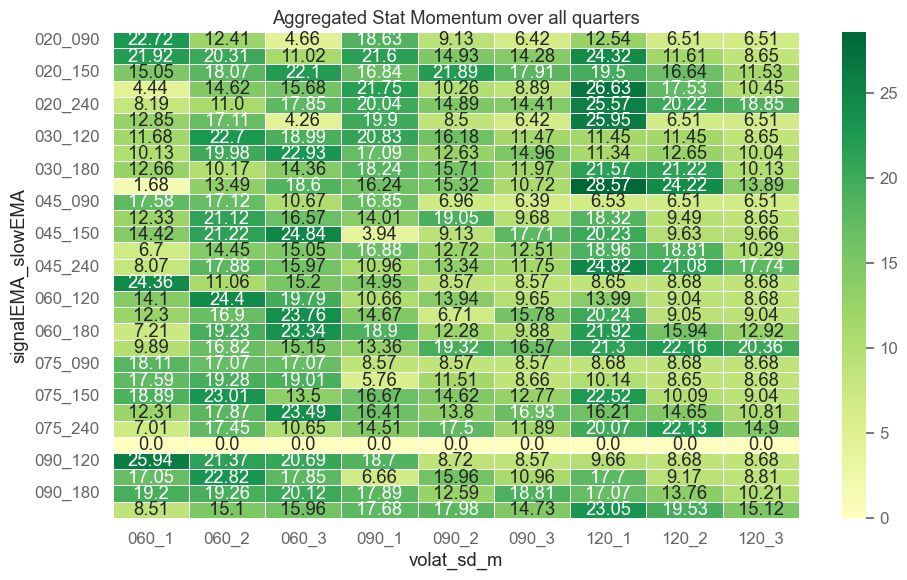

In [67]:

plot_heatmap(
    df=aggregated_stats_breakout_stoploss,
    value_col='stat_mom_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Momentum over all quarters')

#a lot better

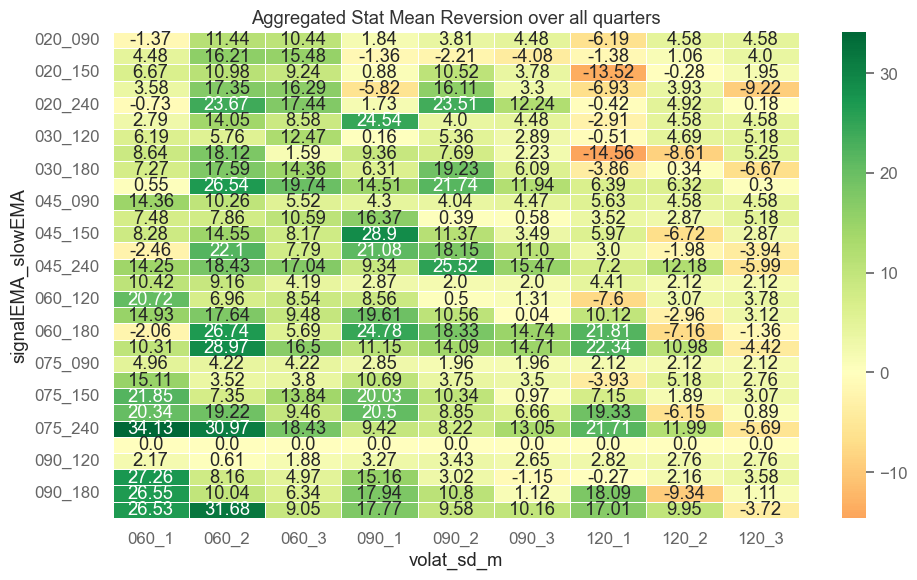

In [68]:
plot_heatmap(
    df=aggregated_stats_breakout_stoploss,
    value_col='stat_mr_total',
    index_col='signalEMA_slowEMA',
    columns_col='volat_sd_m',
    title='Aggregated Stat Mean Reversion over all quarters'
)